In [1]:
import pathlib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, \
                                    cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from catboost import CatBoostRegressor

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
DATA_DIR = pathlib.Path(".")
DATA_FILE = "sc2021_train_deals.csv"
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]
RS = 82567

# Загрузка данных

In [4]:
data = pd.read_csv(DATA_DIR.joinpath(DATA_FILE), parse_dates=["month", "date"])

In [5]:
data.head()

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0


In [6]:
data[:50]

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0
5,133,0,Китай,Китай,16079,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,200.0
6,794,6910,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПП,ПП,Contract + Spot,2018-01-03,693.0
7,965,9781,Россия,Рязанская обл.,13632,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-03,20.0
8,486,9781,Россия,Рязанская обл.,13632,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-03,20.0
9,486,8570,Россия,Алтайский край,17506,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-03,40.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92306 entries, 0 to 92305
Data columns (total 12 columns):
material_code         92306 non-null int64
company_code          92306 non-null int64
country               92306 non-null object
region                92306 non-null object
manager_code          92306 non-null int64
month                 92306 non-null datetime64[ns]
material_lvl1_name    92306 non-null object
material_lvl2_name    92306 non-null object
material_lvl3_name    92306 non-null object
contract_type         92306 non-null object
date                  92306 non-null datetime64[ns]
volume                92306 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 8.5+ MB


Временной диапазон тренировочного множества:

In [8]:
data.month.min(), data.month.max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-07-01 00:00:00'))

In [9]:
data.describe()

,material_code,company_code,manager_code,volume
count,92306.000000,92306.000000,92306.000000,92306.000000
mean,430.662752,3736.563831,14589.355687,33.490131
std,237.791293,3283.773053,2412.087205,46.954516
min,124.000000,0.000000,10642.000000,1.000000
25%,214.000000,0.000000,12444.000000,20.000000
50%,443.000000,3342.000000,14676.000000,20.000000
75%,576.000000,6459.000000,16156.000000,32.000000
max,998.000000,9961.000000,19906.000000,1623.000000


In [10]:
data.isnull().values.any()

False

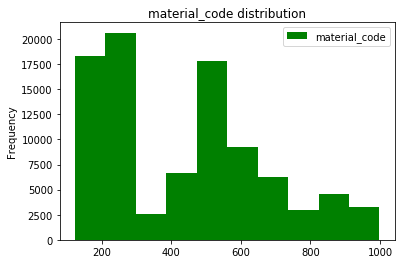

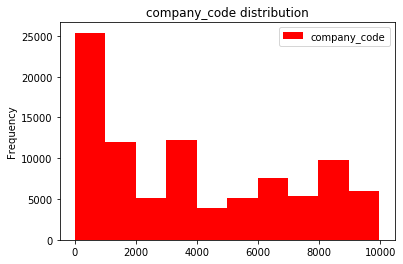

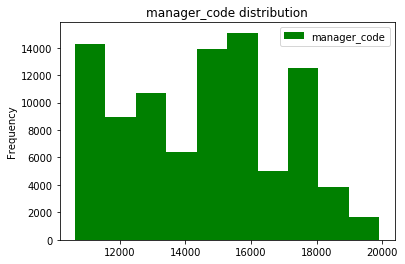

In [11]:
# Ваш код здесь
data.plot(y='material_code', kind='hist', 
           color='green',  title='material_code distribution')
# Ваш код здесь
data.plot(y='company_code', kind='hist', 
           color='red',  title='company_code distribution')
# Ваш код здесь
data.plot(y='manager_code', kind='hist', 
           color='green',  title='manager_code distribution')

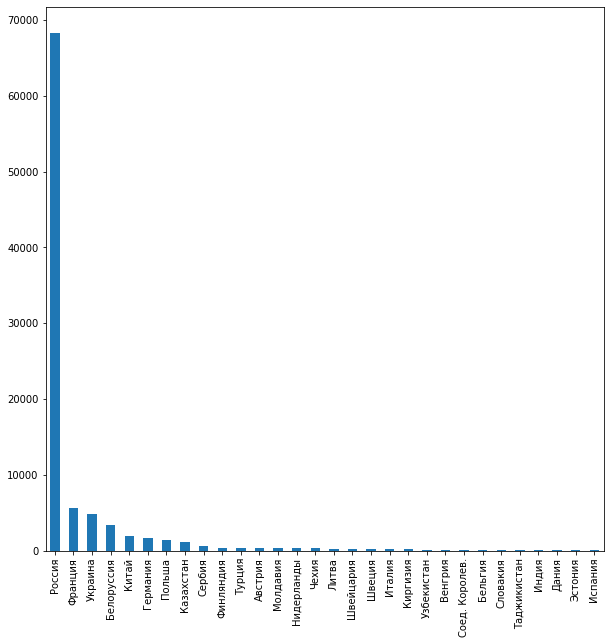

In [12]:
data.country.value_counts().plot(kind='bar', figsize=(10, 10))

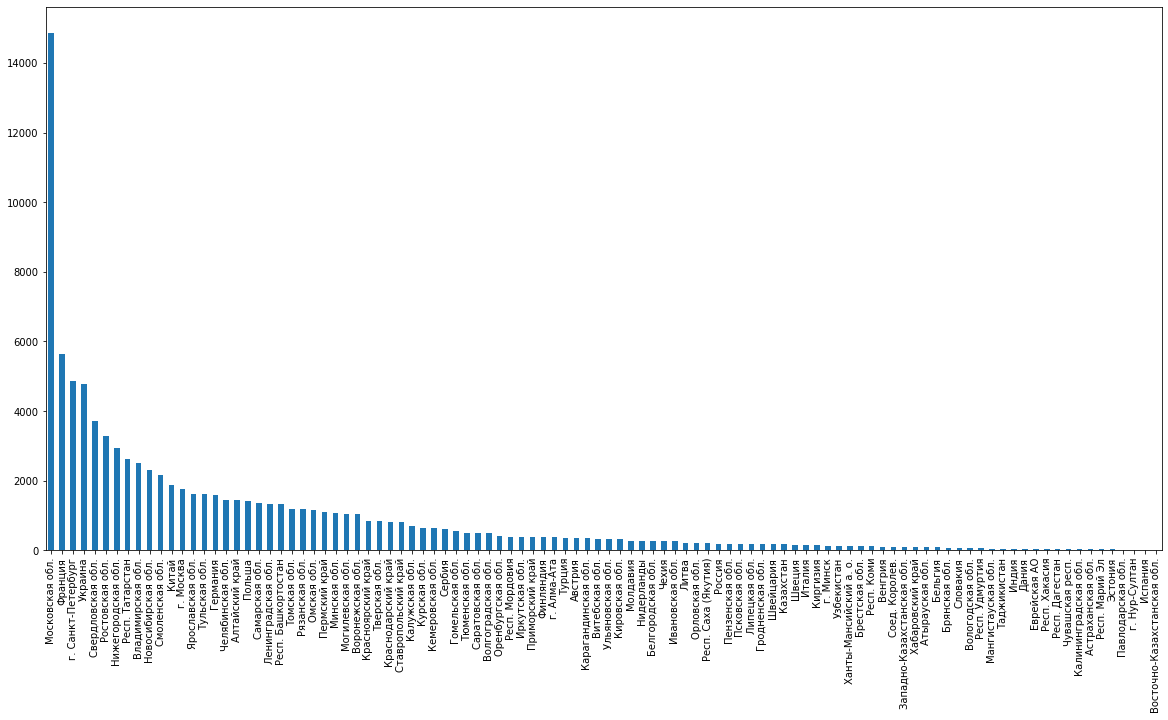

In [13]:
data.region.value_counts().plot(kind='bar', figsize=(20, 10));

# Временные ряды

In [14]:
group_ts = data.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0)

In [15]:
group_ts

month                                                                  2018-01-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              340.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956               60.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-02-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              340.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942               20.0   
                           Казахстан  г. Нур-Султан      13301                0.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956               60.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-03-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              260.0   
133           0            Белоруссия Минская обл.       10942                0.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301               30.0   
...                                                                           ...   
986           9943         Россия     Смоленская обл.    17460                0.0   
998           0            Россия     Ленинградская обл. 18079                0.0   
              3380         Россия     Ленинградская обл. 14956                0.0   
              5410         Россия     г. Санкт-Петербург 14956              100.0   
              6346         Россия     Респ. Башкортостан 10737                0.0   

month                                                                  2018-04-01  \
material_code company_code country    region             manager_code               
124           7278         Россия     Респ. Татарстан    17460              240.0   
133           0            Белоруссия Минская обл.       10942              200.0   
                                      Могилевская обл.   10942                0.0   
                                      г. Минск           10942                0.0   
                           Казахстан  г. Нур-Султан      13301               30.0   
...                                                                           ...   
98

In [16]:
group_ts.index[0]

(124, 7278, 'Россия', 'Респ. Татарстан', 17460)

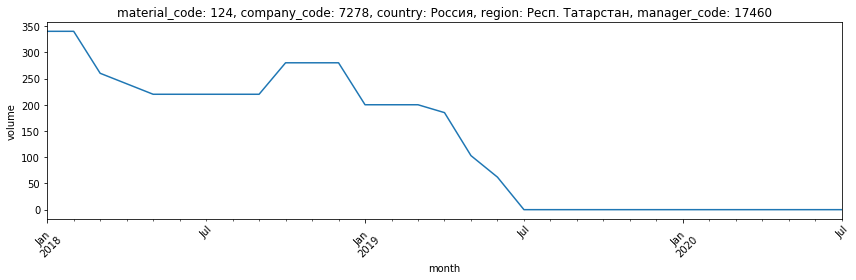

In [17]:
ROW_ID = 0

plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)

title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")

plt.tight_layout()

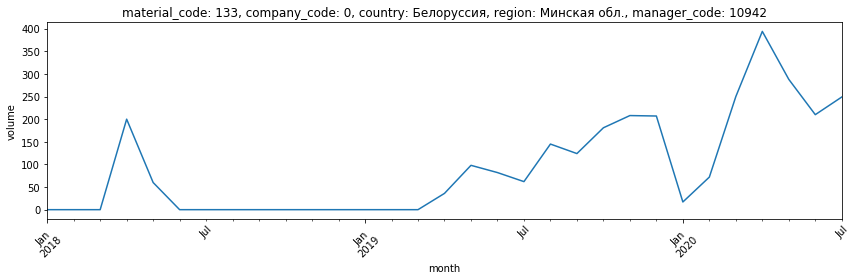

In [18]:
ROW_ID = 1

plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)

title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")

plt.tight_layout()

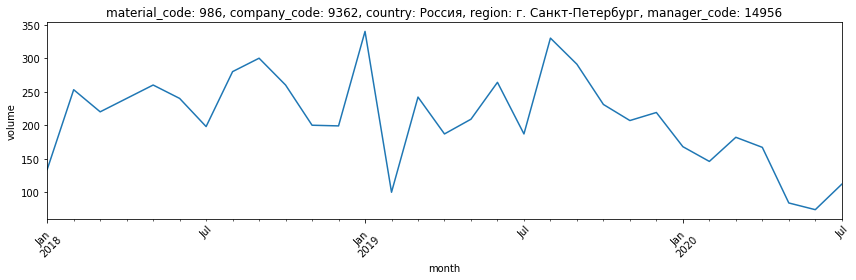

In [19]:
ROW_ID = -7

plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)

title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")

plt.tight_layout()

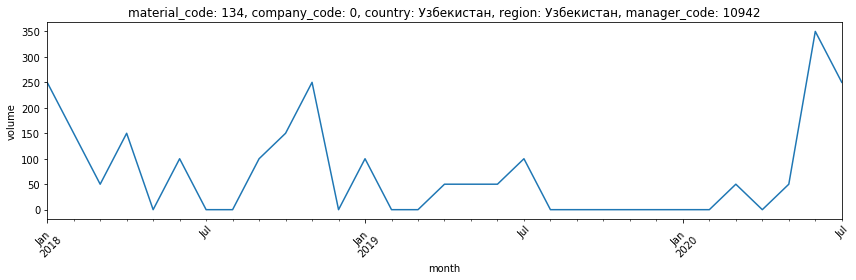

In [20]:
ROW_ID = 100

plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)

title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")

plt.tight_layout()

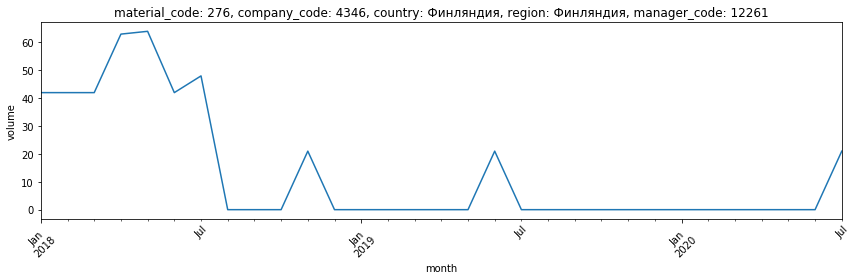

In [21]:
ROW_ID = 349

plt.figure(figsize=(12,4))
group_ts.iloc[ROW_ID].plot(rot=45)

title = ', '.join([f"{k}: {v}" for k, v in zip(AGG_COLS, group_ts.index[ROW_ID])])
plt.title(title, fontsize=12)
plt.ylabel("volume")

plt.tight_layout()

# Обучение

Признаки:

- оригинальные категориальные признаки,
- месяц, для которого предсказываем,
- среднее, минимум, максимум и медиана за год,
- объём за последние 3 месяца до месяца, для которого предсказываем.

Для тренировки будем использовать период `2018-04-01` по `2019-06-01`, для валидации: с `2019-07-01` по `2019-12-01`, для тестирования: с `2020-01-01` по `2020-07-01`.

In [22]:
def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Calculate features for `month`."""

    start_period = month - pd.offsets.MonthBegin(3)
    end_period = month - pd.offsets.MonthBegin(1)

    df = df.loc[:, :end_period]

    features = pd.DataFrame([], index=df.index)
    features[[f"vol_tm{i}" for i in range(3, 0, -1)]] = df.loc[:, start_period:end_period].copy()

    rolling = df.rolling(3, axis=1, min_periods=1)
    features = features.join(rolling.mean().iloc[:, -1].rename("last_3_month_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_3_month_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_3_month_max"))
    features = features.join(rolling.median().iloc[:, -1].rename("last_3_month_median"))
    
    features["vol_tm3**2"] = features["vol_tm3"]**2
    features["vol_tm2**2"] = features["vol_tm2"]**2
    features["vol_tm1**2"] = features["vol_tm1"]**2
    
    features["vol_tm3**3"] = features["vol_tm3"]**3
    features["vol_tm2**3"] = features["vol_tm2"]**3
    features["vol_tm1**3"] = features["vol_tm1"]**3
    
    features["vol_tm3*vol_tm2"] = features["vol_tm3"]*features["vol_tm2"]
    features["vol_tm2*vol_tm1"] = features["vol_tm2"]*features["vol_tm1"]
    features["vol_tm1*vol_tm3"] = features["vol_tm1"]*features["vol_tm3"]
    
    features["vol_tm1*vol_tm2*vol_tm3"] = features["vol_tm1"]*features["vol_tm2"]*features["vol_tm3"]
    
    features["month"] = month.month
    return features

In [23]:
tr_range = pd.date_range("2018-04-01", "2019-06-01", freq="MS")
val_range = pd.date_range("2019-07-01", "2019-12-01", freq="MS")
ts_range = pd.date_range("2020-01-01", "2020-07-01", freq="MS")
full_range = pd.date_range("2018-04-01", "2020-07-01", freq="MS")

In [24]:
full_range

DatetimeIndex(['2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', freq='MS')

In [25]:
full_features = {}

for dataset, dataset_range in zip(["tr", "val", "ts", "fr"], [tr_range, val_range, ts_range, full_range]):
    dataset_features = []
    for target_month in dataset_range:
        features = get_features(group_ts, target_month)
        features["target"] = group_ts[target_month]
        dataset_features.append(features.reset_index())
    full_features[dataset] = pd.concat(dataset_features, ignore_index=True)

In [26]:
CAT_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

NUM_COLS =  ["vol_tm3", "vol_tm2", "vol_tm1", "vol_tm3**2", "vol_tm2**2", "vol_tm1**2",
             "vol_tm3**3", "vol_tm2**3", "vol_tm1**3",
            "vol_tm3*vol_tm2", "vol_tm2*vol_tm1", "vol_tm1*vol_tm3", "vol_tm1*vol_tm2*vol_tm3",
            "last_3_month_avg", "last_3_month_min", "last_3_month_max","last_3_month_median"]
FTS_COLS = ["material_code", "company_code", "country", "region", "manager_code",
            "vol_tm3", "vol_tm2", "vol_tm1","vol_tm3**2", "vol_tm2**2", "vol_tm1**2",
            "vol_tm3**3", "vol_tm2**3", "vol_tm1**3",
            "vol_tm3*vol_tm2", "vol_tm2*vol_tm1", "vol_tm1*vol_tm3", "vol_tm1*vol_tm2*vol_tm3",
            "last_3_month_avg", "last_3_month_min", "last_3_month_max","last_3_month_median"]
TARGET = "target"

In [27]:
full_features["fr"][CAT_COLS] = full_features["fr"][CAT_COLS].astype('str')
full_features["tr"][CAT_COLS] = full_features["tr"][CAT_COLS].astype('str')
full_features["val"][CAT_COLS] = full_features["val"][CAT_COLS].astype('str')
full_features["ts"][CAT_COLS] = full_features["ts"][CAT_COLS].astype('str')

full_features["fr"][CAT_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26348 entries, 0 to 26347
Data columns (total 5 columns):
material_code    26348 non-null object
company_code     26348 non-null object
country          26348 non-null object
region           26348 non-null object
manager_code     26348 non-null object
dtypes: object(5)
memory usage: 1.0+ MB


In [28]:
full_features["fr"][CAT_COLS].count()[0]

26348

In [29]:
for i in CAT_COLS:
    full_features["fr"][i] = full_features["fr"][i] + ["_m"]*full_features["fr"][CAT_COLS].count()[0]
for i in CAT_COLS:   
    full_features["tr"][i] = full_features["tr"][i] + ["_m"]*full_features["tr"][CAT_COLS].count()[0]
for i in CAT_COLS:
    full_features["val"][i] = full_features["val"][i] + ["_m"]*full_features["val"][CAT_COLS].count()[0]
for i in CAT_COLS:
    full_features["ts"][i] = full_features["ts"][i] + ["_m"]*full_features["ts"][CAT_COLS].count()[0]

In [30]:
full_features["fr"][FTS_COLS]

,material_code,company_code,country,region,manager_code,vol_tm3,vol_tm2,vol_tm1,vol_tm3**2,vol_tm2**2,vol_tm1**2,vol_tm3**3,vol_tm2**3,vol_tm1**3,vol_tm3*vol_tm2,vol_tm2*vol_tm1,vol_tm1*vol_tm3,vol_tm1*vol_tm2*vol_tm3,last_3_month_avg,last_3_month_min,last_3_month_max,last_3_month_median
0,124_m,7278_m,Россия_m,Респ. Татарстан_m,17460_m,340.0,340.0,260.0,115600.0,115600.0,67600.0,39304000.0,39304000.0,17576000.0,115600.0,88400.0,88400.0,30056000.0,313.333333,260.0,340.0,340.0
1,133_m,0_m,Белоруссия_m,Минская обл._m,10942_m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,133_m,0_m,Белоруссия_m,Могилевская обл._m,10942_m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,133_m,0_m,Белоруссия_m,г. Минск_m,10942_m,0.0,20.0,0.0,0.0,400.0,0.0,0.0,8000.0,0.0,0.0,0.0,0.0,0.0,6.666667,0.0,20.0,0.0
4,133_m,0_m,Казахстан_m,г. Нур-Султан_m,13301_m,0.0,0.0,30.0,0.0,0.0,900.0,0.0,0.0,27000.0,0.0,0.0,0.0,0.0,10.000000,0.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26343,986_m,9943_m,Россия_m,Смоленская обл._m,17460_m,125.0,84.0,84.0,15625.0,7056.0,7056.0,1953125.0,592704.0,592704.0,10500.0,7056.0,10500.0,882000.0,97.666667,84.0,125.0,84.0
26344,998_m,0_m,Россия_m,Ленинградская обл._m,18079_m,0.0,3.0,3.0,0.0,9.0,9.0,0.0,27.0,27.0,0.0,9.0,0.0,0.0,2.000000,0.0,3.0,3.0
26345,998_m,3380_m,Россия_m,Ленинградская обл._m,14956_m,100.0,15.0,30.0,10000.0,225.0,900.0,1000000.0,3375.0,27000.0,1500.0,450.0,3000.0,45000.0,48.333333,15.0,100.0,30.0
26346,998_m,5410_m,Россия_m,г. Санкт-Петербург_m,14956_m,100.0,140.0,40.0,10000.0,19600.0,1600.0,1000000.0,2744000.0,64000.0,14000.0,5600.0,4000.0,560000.0,93.333333,40.0,140.0,100.0


In [31]:
x = data.country.value_counts().to_dict()
print(x.values())
print(x.keys())

dict_values([68300, 5652, 4781, 3414, 1871, 1602, 1405, 1180, 624, 383, 363, 358, 281, 279, 276, 223, 182, 160, 157, 145, 127, 109, 107, 82, 72, 47, 44, 42, 23, 17])
dict_keys(['Россия', 'Франция', 'Украина', 'Белоруссия', 'Китай', 'Германия', 'Польша', 'Казахстан', 'Сербия', 'Финляндия', 'Турция', 'Австрия', 'Молдавия', 'Нидерланды', 'Чехия', 'Литва', 'Швейцария', 'Швеция', 'Италия', 'Киргизия', 'Узбекистан', 'Венгрия', 'Соед. Королев.', 'Бельгия', 'Словакия', 'Таджикистан', 'Индия', 'Дания', 'Эстония', 'Испания'])


In [32]:
#import math as m

In [33]:
#copy_dict = {}
#for i,j in zip(x.keys(), x.values()):
#    c = int(x['Россия']/x[i])
#    copy_dict[i] = int(m.log2(c))
#
#copy_dict

In [34]:
#del copy_dict['Россия']

In [35]:
#copy_dict

In [36]:
#copy_dict = {'Франция': 1,
# 'Германия': 1,
# 'Сербия': 2,
# 'Финляндия': 1,
# 'Турция': 1,
# 'Австрия': 1,
# 'Молдавия': 1,
# 'Нидерланды': 2,
# 'Чехия': 1,
# 'Литва': 2,
# 'Швейцария': 2,
# 'Швеция': 2,
# 'Италия': 2,
# 'Киргизия': 2,
# 'Узбекистан': 2,
# 'Венгрия': 2,
# 'Соед. Королев.': 2,
# 'Бельгия': 2,
# 'Словакия': 2,
# 'Таджикистан': 2,
# 'Индия': 2,
# 'Дания': 2,
# 'Эстония': 2,
# 'Испания': 2}
#copy_dict

In [37]:
#for i in copy_dict.keys():
#    copy_dict[i] = 5
#copy_dict

### Oversampling

In [38]:
#for i in copy_dict.keys():
#        for j in range(0, copy_dict[i]-1):
#            full_features["fr"] = full_features["fr"].append(full_features["fr"][full_features["fr"].country == i], ignore_index=True)

In [39]:
#full_features["fr"].append(full_features["fr"][full_features["fr"].country == 'Франция'], ignore_index=True)

In [40]:
#full_features["fr"]

In [41]:
#full_features["fr"].to_csv('full_features.csv', index=False)

In [42]:
#full_features_shuffled = shuffle(full_features["fr"], random_state=RS)

In [43]:
#full_features_shuffled.country.value_counts().plot(kind='bar', figsize=(10, 10))

In [44]:
#full_features_shuffled[FTS_COLS].corrwith(full_features_shuffled["target"])

In [45]:
#full_features["fr"][FTS_COLS].corrwith(full_features["fr"]["target"])

In [46]:
#full_features_shuffled[FTS_COLS].corr()

In [47]:
#full_features["fr"][FTS_COLS].corr()

In [48]:
#full_features_shuffled[FTS_COLS  + [TARGET]]

In [49]:
#full_features['fr'][FTS_COLS  + [TARGET]]

In [50]:
for i in x.keys():
    d = full_features["fr"][full_features["fr"].country == i+"_m"]
    print("Corr for: ", i)
    print(d[FTS_COLS].corrwith(d["target"]))

Corr for:  Россия
vol_tm3                    0.740381
vol_tm2                    0.773811
vol_tm1                    0.842902
vol_tm3**2                 0.593959
vol_tm2**2                 0.626876
vol_tm1**2                 0.709980
vol_tm3**3                 0.479333
vol_tm2**3                 0.510476
vol_tm1**3                 0.599998
vol_tm3*vol_tm2            0.624217
vol_tm2*vol_tm1            0.681586
vol_tm1*vol_tm3            0.660573
vol_tm1*vol_tm2*vol_tm3    0.538154
last_3_month_avg           0.835272
last_3_month_min           0.760979
last_3_month_max           0.824742
last_3_month_median        0.813307
dtype: float64
Corr for:  Франция
vol_tm3                    0.764993
vol_tm2                    0.840186
vol_tm1                    0.821184
vol_tm3**2                 0.719810
vol_tm2**2                 0.810948
vol_tm1**2                 0.751623
vol_tm3**3                 0.665959
vol_tm2**3                 0.767848
vol_tm1**3                 0.672744
vol_tm3*vol_

Corr for:  Литва
vol_tm3                    0.245084
vol_tm2                    0.160664
vol_tm1                    0.524688
vol_tm3**2                 0.230211
vol_tm2**2                 0.044292
vol_tm1**2                 0.491184
vol_tm3**3                 0.188474
vol_tm2**3                -0.010574
vol_tm1**3                 0.449707
vol_tm3*vol_tm2            0.115704
vol_tm2*vol_tm1            0.170982
vol_tm1*vol_tm3            0.251655
vol_tm1*vol_tm2*vol_tm3    0.066887
last_3_month_avg           0.395960
last_3_month_min           0.025986
last_3_month_max           0.488461
last_3_month_median        0.294931
dtype: float64
Corr for:  Швейцария
vol_tm3                    0.118028
vol_tm2                    0.164433
vol_tm1                    0.161508
vol_tm3**2                 0.000080
vol_tm2**2                 0.050016
vol_tm1**2                 0.041968
vol_tm3**3                -0.046986
vol_tm2**3                -0.021983
vol_tm1**3                -0.018505
vol_tm3*vol

In [51]:
#sns.pairplot(full_features["fr"][FTS_COLS  + [TARGET]])

In [52]:
for_linear_models = ['Россия_m', 'Франция_m', 'Украина_m', 'Белоруссия_m', 'Китай_m', 'Германия_m',
                     'Казахстан_m', 'Сербия_m', 'Финляндия_m', 'Нидерланды_m', 
                     'Швеция_m', 'Италия_m', 'Венгрия_m', 'Бельгия_m', 'Эстония_m', 'Испания_m']
for_unlinear_models = [ 'Польша_m', 'Турция_m', 'Австрия_m', 'Молдавия_m', 'Чехия_m', 'Литва_m', 
                       'Швейцария_m', 'Киргизия_m', 'Узбекистан_m', 'Соед. Королев._m', 
                       'Словакия_m', 'Таджикистан_m', 'Индия_m', 'Дания_m']

In [53]:
encoder = DV(sparse = False)
full_features_CAT_COLS_en = encoder.fit_transform(full_features["fr"][CAT_COLS].T.to_dict().values())
tr_features_CAT_COLS_en = encoder.transform(full_features["tr"][CAT_COLS].T.to_dict().values())
val_features_CAT_COLS_en = encoder.transform(full_features["val"][CAT_COLS].T.to_dict().values())
ts_features_CAT_COLS_en = encoder.transform(full_features["ts"][CAT_COLS].T.to_dict().values())
#full_features_shuffled_CAT_COLS_en = encoder.transform(full_features_shuffled[CAT_COLS].T.to_dict().values())

In [54]:
full_features["fr"][FTS_COLS][0:1]

,material_code,company_code,country,region,manager_code,vol_tm3,vol_tm2,vol_tm1,vol_tm3**2,vol_tm2**2,vol_tm1**2,vol_tm3**3,vol_tm2**3,vol_tm1**3,vol_tm3*vol_tm2,vol_tm2*vol_tm1,vol_tm1*vol_tm3,vol_tm1*vol_tm2*vol_tm3,last_3_month_avg,last_3_month_min,last_3_month_max,last_3_month_median
0,124_m,7278_m,Россия_m,Респ. Татарстан_m,17460_m,340.0,340.0,260.0,115600.0,115600.0,67600.0,39304000.0,39304000.0,17576000.0,115600.0,88400.0,88400.0,30056000.0,313.333333,260.0,340.0,340.0


In [55]:
tr_features_CAT_COLS_en[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [56]:
encoder.inverse_transform(tr_features_CAT_COLS_en)[0]

{'company_code=7278_m': 1.0,
 'country=Россия_m': 1.0,
 'manager_code=17460_m': 1.0,
 'material_code=124_m': 1.0,
 'region=Респ. Татарстан_m': 1.0}

In [57]:
# save
with open('encoder.pkl','wb') as f:
    pickle.dump(encoder,f)

In [58]:
x = pd.concat([full_features["tr"][NUM_COLS], full_features["val"][NUM_COLS]], ignore_index=True)
y = pd.concat([full_features["tr"][TARGET], full_features["val"][TARGET]], ignore_index=True)

In [59]:
scaler = StandardScaler()
scaler.fit(x, y)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [60]:
# save
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

In [61]:
tr_features_NUM_COLS_scaled = scaler.transform(full_features["tr"][NUM_COLS])
val_features_NUM_COLS_scaled = scaler.transform(full_features["val"][NUM_COLS])
ts_features_NUM_COLS_scaled = scaler.transform(full_features["ts"][NUM_COLS])
full_features_NUM_COLS_scaled = scaler.transform(full_features["fr"][NUM_COLS])
#full_features_shuffled_NUM_COLS_scaled = scaler.transform(full_features_shuffled[NUM_COLS])

In [62]:
#tr_features_NUM_COLS_scaled[0]

In [63]:
#tr_features_CAT_COLS_en[0]

In [64]:
X_tr = np.hstack((tr_features_NUM_COLS_scaled, tr_features_CAT_COLS_en))
X_val  = np.hstack((val_features_NUM_COLS_scaled, val_features_CAT_COLS_en))
X_ts = np.hstack((ts_features_NUM_COLS_scaled, ts_features_CAT_COLS_en))
X = np.hstack((full_features_NUM_COLS_scaled, full_features_CAT_COLS_en))
#X = np.hstack((full_features_shuffled_NUM_COLS_scaled, full_features_shuffled_CAT_COLS_en))

In [65]:
y_tr = full_features["tr"][TARGET]
y_val = full_features["val"][TARGET]
y_ts = full_features["ts"][TARGET]
y = full_features["fr"][TARGET]
#y = full_features_shuffled[TARGET]

In [66]:
#кореляции после энкодинга

In [67]:
c = pd.DataFrame(X)
t = pd.DataFrame(y)

In [68]:
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526
0,0.799489,0.788640,0.520729,0.013819,0.012288,-0.033885,-0.049310,-0.049685,-0.054466,0.030276,0.000357,0.005013,-0.049550,0.746292,0.878014,0.547911,0.810669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.324995,-0.328851,-0.333354,-0.096189,-0.096822,-0.098648,-0.057224,-0.057522,-0.058052,-0.095394,-0.096563,-0.090255,-0.058026,-0.349480,-0.279358,-0.382215,-0.325127,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.324995,-0.328851,-0.333354,-0.096189,-0.096822,-0.098648,-0.057224,-0.057522,-0.058052,-0.095394,-0.096563,-0.090255,-0.058026,-0.349480,-0.279358,-0.382215,-0.325127,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.324995,-0.263116,-0.333354,-0.096189,-0.096444,-0.098648,-0.057224,-0.057521,-0.058052,-0.095394,-0.096563,-0.090255,-0.058026,-0.326166,-0.279358,-0.327502,-0.325127,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.324995,-0.328851,-0.234806,-0.096189,-0.096822,-0.097786,-0.057224,-0.057522,-0.058047,-0.095394,-0.096563,-0.090255,-0.058026,-0.314509,-0.279358,-0.300146,-0.325127,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26343,0.088418,-0.052765,-0.057419,-0.081320,-0.090162,-0.091888,-0.056831,-0.057404,-0.057931,-0.083979,-0.088827,-0.078939,-0.057777,-0.007926,0.094562,-0.040257,-0.044519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26344,-0.324995,-0.318991,-0.323499,-0.096189,-0.096813,-0.098639,-0.057224,-0.057522,-0.058052,-0.095394,-0.096553,-0.090255,-0.058026,-0.342486,-0.279358,-0.374008,-0.315105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [69]:
t

,target
0,240.0
1,200.0
2,0.0
3,0.0
4,30.0
...,...
26343,83.0
26344,9.0
26345,50.0
26346,0.0


In [70]:
corr = c.corrwith(t["target"])
for i in range(0,corr.shape[0]):
    if(corr[i]>0.30):
        print(str(i) + ":" + str(corr[i]))

0:0.7121989818907841
1:0.7455122126442723
2:0.80227663516885
3:0.5778873044172633
4:0.6073033598037709
5:0.6533688795594506
6:0.457799876500671
7:0.48534893770177023
8:0.5088134754790027
9:0.6093768728905711
10:0.6481387517948841
11:0.6172531192293064
12:0.5012078489778935
13:0.8109392033779719
14:0.7194353943450259
15:0.7965433138150643
16:0.794816106478956
89:0.3285872960475479
195:0.30644948330478805


### Данные для линейных моделей

In [71]:
def generateData(df: pd.DataFrame, country:[]):
    frame = pd.DataFrame()
    for i in country:
        frame = frame.append(df[df.country == i],ignore_index=True)
    return frame

In [72]:
X_tr_num = generateData(full_features["tr"], for_linear_models)[NUM_COLS] 
X_val_num = generateData(full_features["val"], for_linear_models)[NUM_COLS]  
X_ts_num = generateData(full_features["ts"], for_linear_models)[NUM_COLS]   
X_fr_num = generateData(full_features["fr"], for_linear_models)[NUM_COLS]   

In [73]:
X_tr_num_sc = scaler.transform(X_tr_num)
X_val_num_sc = scaler.transform(X_val_num)  
X_ts_num_sc = scaler.transform(X_ts_num)   
X_fr_num_sc = scaler.transform(X_fr_num)

In [74]:
y_tr_num = generateData(full_features["tr"], for_linear_models)[TARGET] 
y_val_num = generateData(full_features["val"], for_linear_models)[TARGET]  
y_ts_num = generateData(full_features["ts"], for_linear_models)[TARGET]   
y_fr_num = generateData(full_features["fr"], for_linear_models)[TARGET]  

### Данные для нелинейных моделей

In [75]:
X_tr_cat = generateData(full_features["tr"], for_unlinear_models)[CAT_COLS] 
X_val_cat = generateData(full_features["val"], for_unlinear_models)[CAT_COLS]  
X_ts_cat = generateData(full_features["ts"], for_unlinear_models)[CAT_COLS]   
X_fr_cat = generateData(full_features["fr"], for_unlinear_models)[CAT_COLS]

In [76]:
X_tr_cat_en = encoder.transform(X_tr_cat.T.to_dict().values())
X_val_cat_en = encoder.transform(X_val_cat.T.to_dict().values())
X_ts_cat_en = encoder.transform(X_ts_cat.T.to_dict().values())
X_fr_cat_en = encoder.transform(X_fr_cat.T.to_dict().values())

In [77]:
y_tr_cat = generateData(full_features["tr"], for_unlinear_models)[TARGET] 
y_val_cat = generateData(full_features["val"], for_unlinear_models)[TARGET]  
y_ts_cat = generateData(full_features["ts"], for_unlinear_models)[TARGET]   
y_fr_cat = generateData(full_features["fr"], for_unlinear_models)[TARGET]

In [78]:
from random import randint

def rand(X_):
    for i in range(2,len(X_)-2):
        a = np.random.poisson()
        if(X_[i]==0):
            if(a>4):
                X_[i]=X_[i+2]
        else:
            if(a>4):
                X_[i-2]=0
    return X_

In [79]:
tr_preds = generateData(full_features["tr"], for_unlinear_models)['last_3_month_avg']
val_preds = generateData(full_features["val"], for_unlinear_models)['last_3_month_avg'] 
ts_preds = generateData(full_features["ts"], for_unlinear_models)['last_3_month_avg']

tr_preds = rand(tr_preds)
val_preds = rand(val_preds)
ts_preds = rand(ts_preds)


print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_cat, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_cat, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_cat, ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.9847
Ошибка на валидационном множестве: 2.5878
Ошибка на тестовом множестве: 2.6610


Ошибка на тренировочном множестве: 1.9760
Ошибка на валидационном множестве: 2.5785
Ошибка на тестовом множестве: 2.6375

In [80]:
#y = generateData(full_features["tr"], for_unlinear_models).iloc[[1],:]['last_3_month_avg']

In [81]:
#y.iloc[0]

## Кросс валидация

In [82]:
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_fr_num_sc, y_fr_num, 
                                                    test_size=0.2, shuffle=False, random_state=RS)

In [83]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_fr_cat_en, y_fr_cat, 
                                                    test_size=0.2, shuffle=False, random_state=RS)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=RS)

In [85]:
cv_strategy_KFold = KFold(n_splits=5, random_state=RS, shuffle=False)
cv_strategy_TMS = TimeSeriesSplit(n_splits=5)

In [86]:
scorer = metrics.make_scorer(metrics.mean_absolute_error)
scorerCV = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False)

## linear_regressor

In [87]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train_num, y_train_num)
predictions = linear_regressor.predict(X_test_num)

In [88]:
# save
with open('linear_regressor.pkl','wb') as f:
    pickle.dump(linear_regressor,f)

In [89]:
metrics.mean_absolute_error(y_test_num, predictions)

103.78602992513561

In [90]:
tr_preds = linear_regressor.predict(X_tr_num_sc)
val_preds = linear_regressor.predict(X_val_num_sc)
ts_preds = linear_regressor.predict(X_ts_num_sc)

In [91]:
tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

In [92]:
print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_num, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_num, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_num, ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.8561
Ошибка на валидационном множестве: 1.7584
Ошибка на тестовом множестве: 1.9910


In [93]:
#linear_regressor.coef_

In [94]:
lr_scoring = cross_val_score(linear_regressor, X_train_num, y_train_num, scoring = scorer, cv = cv_strategy_KFold)
print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(lr_scoring .mean(), lr_scoring .max(), 
                                                     lr_scoring .min(), lr_scoring .std()))

LR (KFold)) mean:44.24685262749994, max:49.67718757136168, min:39.13465825880776, std:3.644916468699221


In [95]:
lr_scoring

array([39.13465826, 44.92829021, 41.52894768, 45.96517942, 49.67718757])

In [96]:
lr_scoring = cross_val_score(linear_regressor, X_train_num, y_train_num, scoring = scorer, cv = cv_strategy_TMS)
print ('LR (TMS)) mean:{}, max:{}, min:{}, std:{}'.format(lr_scoring .mean(), lr_scoring .max(), 
                                                     lr_scoring .min(), lr_scoring .std()))

LR (TMS)) mean:46.2375614077792, max:51.81623842685031, min:42.23737306731356, std:3.2016593436303022


In [97]:
lr_scoring

array([47.17813774, 44.78771258, 42.23737307, 45.16834522, 51.81623843])

In [98]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_tr_num_sc, y_tr_num)

tr_preds = linear_regressor.predict(X_tr_num_sc)
val_preds = linear_regressor.predict(X_val_num_sc)
ts_preds = linear_regressor.predict(X_ts_num_sc)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_num, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_num, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_num, ts_preds)):.4f}')
      
# save
#with open('linear_regressor.pkl','wb') as f:
#    pickle.dump(linear_regressor,f)

Ошибка на тренировочном множестве: 1.8880
Ошибка на валидационном множестве: 1.7724
Ошибка на тестовом множестве: 2.0031


## Lasso

In [99]:
lasso_regressor = linear_model.Lasso(random_state=RS)
lasso_regressor.fit(X_train_num, y_train_num)
predictions = lasso_regressor.predict(X_test_num)

In [100]:
# save
with open('lasso_regressor.pkl','wb') as f:
    pickle.dump(lasso_regressor,f)

In [101]:
metrics.mean_absolute_error(y_test_num, predictions)

99.8807658177995

In [102]:
tr_preds = lasso_regressor.predict(X_tr_num_sc)
val_preds = lasso_regressor.predict(X_val_num_sc)
ts_preds = lasso_regressor.predict(X_ts_num_sc)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_num, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_num, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_num, ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.7819
Ошибка на валидационном множестве: 1.7066
Ошибка на тестовом множестве: 1.9338


In [103]:
lasso_regressor.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [104]:
#parameters_grid = {
#    'alpha' : [0.5, 1, 1.5, 2],
#    'tol' : [0.00001, 0.0001, 0.001],
#    'max_iter': [500, 1000, 2000],
#}

In [105]:
#grid_cv = GridSearchCV(lasso_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_KFold)

In [106]:
#%%time
#grid_cv.fit(X_train, y_train)

In [107]:
#grid_cv.best_estimator_

In [108]:
#print(grid_cv.best_score_)
#print(grid_cv.best_params_)

In [109]:
#predictions = grid_cv.predict(X_test)
#metrics.mean_absolute_error(y_test, predictions)

In [110]:
#linear_regressor.coef_

In [111]:
lr_scoring = cross_val_score(lasso_regressor, X_train_num, y_train_num, scoring = scorer, cv = cv_strategy_KFold)
print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(lr_scoring .mean(), lr_scoring .max(), 
                                                     lr_scoring .min(), lr_scoring .std()))

LR (KFold)) mean:43.20707954786475, max:48.646989894283756, min:38.87395566189979, std:3.4101045565764916


In [112]:
lr_scoring

array([38.87395566, 43.52088582, 40.41496162, 44.57860474, 48.64698989])

In [113]:
lr_scoring = cross_val_score(lasso_regressor, X_train_num, y_train_num, scoring = scorer, cv = cv_strategy_TMS)
print ('LR (TMS)) mean:{}, max:{}, min:{}, std:{}'.format(lr_scoring .mean(), lr_scoring .max(), 
                                                     lr_scoring .min(), lr_scoring .std()))

LR (TMS)) mean:45.21247941567664, max:51.05345881926269, min:40.6805669764514, std:3.474313563337491


In [114]:
lr_scoring

array([46.57706999, 44.23805456, 40.68056698, 43.51324673, 51.05345882])

In [115]:
lasso_regressor = linear_model.Lasso(random_state=RS)
lasso_regressor.fit(X_tr_num_sc, y_tr_num)

tr_preds = lasso_regressor.predict(X_tr_num_sc)
val_preds = lasso_regressor.predict(X_val_num_sc)
ts_preds = lasso_regressor.predict(X_ts_num_sc)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_num, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_num, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_num, ts_preds)):.4f}')
      
# save
#with open('lasso_regressor.pkl','wb') as f:
#    pickle.dump(lasso_regressor,f)

Ошибка на тренировочном множестве: 1.9098
Ошибка на валидационном множестве: 1.7736
Ошибка на тестовом множестве: 1.9988


## ridge_regressor

In [116]:
ridge_regressor = linear_model.Ridge(random_state=RS)
ridge_regressor.fit(X_train, y_train)
predictions = ridge_regressor.predict(X_test)

In [117]:
# save
with open('ridge_regressor.pkl','wb') as f:
    pickle.dump(ridge_regressor,f)

In [118]:
metrics.mean_absolute_error(y_test, predictions)

85.00169367561698

In [119]:
tr_preds = ridge_regressor.predict(X_tr)
val_preds = ridge_regressor.predict(X_val)
ts_preds = ridge_regressor.predict(X_ts)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts, ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.9915
Ошибка на валидационном множестве: 1.8487
Ошибка на тестовом множестве: 2.0452


In [120]:
rd_ts_preds = ts_preds

In [121]:
ridge_regressor.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [122]:
#parameters_grid = {
#    'alpha' : [0.5, 1, 1.5, 2],
#    'tol' : [0.00001, 0.0001, 0.001],
#    'max_iter': [500, 1000, 2000],
#}

In [123]:
#grid_cv = GridSearchCV(ridge_regressor, parameters_grid, scoring = scorerCV, cv = cv_strategy_KFold)

In [124]:
#%%time
#grid_cv.fit(X_train, y_train)

In [125]:
#grid_cv.best_estimator_

In [126]:
#print(grid_cv.best_score_)
#print(grid_cv.best_params_)

In [127]:
#predictions = grid_cv.predict(X_test)
#metrics.mean_absolute_error(y_test, predictions)

In [128]:
#rd_scoring = cross_val_score(ridge_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_KFold)
#print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(rd_scoring .mean(), rd_scoring .max(), 
#                                                     rd_scoring .min(), rd_scoring .std()))

In [129]:
#rd_scoring

In [130]:
#rd_scoring = cross_val_score(ridge_regressor, X_train, y_train, scoring = scorer, cv = cv_strategy_TMS)
#print ('LR (KFold)) mean:{}, max:{}, min:{}, std:{}'.format(rd_scoring .mean(), rd_scoring .max(), 
#                                                     rd_scoring .min(), rd_scoring .std()))

In [131]:
#rd_scoring

In [132]:
ridge_regressor = linear_model.Ridge(random_state=RS)
ridge_regressor.fit(X_tr_num_sc, y_tr_num)

tr_preds = ridge_regressor.predict(X_tr_num_sc)
val_preds = ridge_regressor.predict(X_val_num_sc)
ts_preds = ridge_regressor.predict(X_ts_num_sc)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_num, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_num, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_num, ts_preds)):.4f}')
      
# save
#with open('ridge_regressor.pkl','wb') as f:
#    pickle.dump(ridge_regressor,f)

Ошибка на тренировочном множестве: 1.8841
Ошибка на валидационном множестве: 1.7694
Ошибка на тестовом множестве: 1.9998


## SGD_regressor

In [133]:
SGD_regressor = linear_model.SGDRegressor(shuffle=False, random_state=RS)
#SGD_regressor = linear_model.SGDRegressor(alpha=0.001, eta0=0.001, penalty='l1', power_t=0.3,
#                                          random_state=82567, shuffle=False, tol=1.5)
SGD_regressor.fit(X_train_num, y_train_num)
predictions = SGD_regressor.predict(X_test_num)

C:\Users\rniva\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [134]:
# save
with open('SGD_regressor.pkl','wb') as f:
    pickle.dump(SGD_regressor,f)

In [135]:
metrics.mean_absolute_error(y_test_num, predictions)

101.88153399368846

In [136]:
tr_preds = SGD_regressor.predict(X_tr_num_sc)
val_preds = SGD_regressor.predict(X_val_num_sc)
ts_preds = SGD_regressor.predict(X_ts_num_sc)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_num, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_num, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_num, ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.5807
Ошибка на валидационном множестве: 1.6267
Ошибка на тестовом множестве: 1.8460


In [137]:
SGD_regressor.get_params().keys()

dict_keys(['alpha', 'average', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [138]:
#parameters_grid = {
#    'penalty' : ['l1', 'l2'],
#    'alpha' : [0.00005, 0.0001, 0.001,0.0001],
#    'eta0' : [0.001, 0.005, 0.01, 0.05],
#     'tol' : [0.5,1, 1.5],
#    'power_t' : [0.2,0.25, 0.3], 
#    
#}

In [139]:
#randomized_grid_cv = RandomizedSearchCV(SGD_regressor, parameters_grid, scoring = scorerCV, \
#                                        cv = cv_strategy_KFold, n_iter = 200, random_state=0)

In [140]:
#%%time
#randomized_grid_cv.fit(X_train_num, y_train_num)

In [141]:
#randomized_grid_cv.best_estimator_

In [142]:
#print(randomized_grid_cv.best_score_)
#print(randomized_grid_cv.best_params_)

In [143]:
#predictions = randomized_grid_cv.predict(X_test_num)
#metrics.mean_absolute_error(y_test_num, predictions)

In [144]:
SGD_regressor = linear_model.SGDRegressor(shuffle=False, random_state=RS)
SGD_regressor.fit(X_tr_num_sc, y_tr_num)

tr_preds = SGD_regressor.predict(X_tr_num_sc)
val_preds = SGD_regressor.predict(X_val_num_sc)
ts_preds = SGD_regressor.predict(X_ts_num_sc)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_num, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_num, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_num, ts_preds)):.4f}')
      
# save
#with open('SGD_regressor.pkl','wb') as f:
#    pickle.dump(SGD_regressor,f)

Ошибка на тренировочном множестве: 10.0979
Ошибка на валидационном множестве: 11.3748
Ошибка на тестовом множестве: 10.4380


## CatBoostRegressor

In [145]:
model = CatBoostRegressor(random_state=RS)
model.fit(X_train_num, y_train_num)
predictions = model.predict(X_test_num)

Learning rate set to 0.066177
0:	learn: 242.4799986	total: 172ms	remaining: 2m 52s
1:	learn: 232.1804377	total: 207ms	remaining: 1m 43s
2:	learn: 222.6914556	total: 233ms	remaining: 1m 17s
3:	learn: 213.8240982	total: 255ms	remaining: 1m 3s
4:	learn: 205.9707748	total: 277ms	remaining: 55.1s
5:	learn: 198.4633161	total: 302ms	remaining: 50.1s
6:	learn: 191.4297721	total: 333ms	remaining: 47.2s
7:	learn: 185.0246902	total: 353ms	remaining: 43.8s
8:	learn: 179.1934511	total: 374ms	remaining: 41.2s
9:	learn: 173.9661632	total: 391ms	remaining: 38.7s
10:	learn: 169.2284557	total: 414ms	remaining: 37.2s
11:	learn: 164.8615397	total: 437ms	remaining: 36s
12:	learn: 160.8698304	total: 457ms	remaining: 34.7s
13:	learn: 157.0983226	total: 473ms	remaining: 33.3s
14:	learn: 153.8894368	total: 490ms	remaining: 32.2s
15:	learn: 150.9177292	total: 505ms	remaining: 31s
16:	learn: 148.1322424	total: 521ms	remaining: 30.1s
17:	learn: 145.6645414	total: 540ms	remaining: 29.4s
18:	learn: 143.2986343	tota

162:	learn: 99.7480943	total: 3.81s	remaining: 19.6s
163:	learn: 99.7120778	total: 3.83s	remaining: 19.5s
164:	learn: 99.5998573	total: 3.85s	remaining: 19.5s
165:	learn: 99.4450364	total: 3.87s	remaining: 19.4s
166:	learn: 99.3471078	total: 3.88s	remaining: 19.4s
167:	learn: 99.1989168	total: 3.9s	remaining: 19.3s
168:	learn: 99.1643371	total: 3.92s	remaining: 19.3s
169:	learn: 99.1103313	total: 3.93s	remaining: 19.2s
170:	learn: 98.9524551	total: 3.94s	remaining: 19.1s
171:	learn: 98.9048239	total: 3.96s	remaining: 19.1s
172:	learn: 98.7723513	total: 3.98s	remaining: 19s
173:	learn: 98.6740530	total: 3.99s	remaining: 19s
174:	learn: 98.6098909	total: 4.01s	remaining: 18.9s
175:	learn: 98.5794110	total: 4.03s	remaining: 18.9s
176:	learn: 98.5006524	total: 4.04s	remaining: 18.8s
177:	learn: 98.3728637	total: 4.06s	remaining: 18.7s
178:	learn: 98.2297937	total: 4.07s	remaining: 18.7s
179:	learn: 98.2010282	total: 4.08s	remaining: 18.6s
180:	learn: 98.1734468	total: 4.1s	remaining: 18.5s

323:	learn: 89.6855403	total: 6.85s	remaining: 14.3s
324:	learn: 89.6545075	total: 6.87s	remaining: 14.3s
325:	learn: 89.6258253	total: 6.89s	remaining: 14.2s
326:	learn: 89.5857230	total: 6.91s	remaining: 14.2s
327:	learn: 89.5042302	total: 6.92s	remaining: 14.2s
328:	learn: 89.4121023	total: 6.94s	remaining: 14.2s
329:	learn: 89.3643334	total: 6.96s	remaining: 14.1s
330:	learn: 89.3125867	total: 6.97s	remaining: 14.1s
331:	learn: 89.2859234	total: 6.99s	remaining: 14.1s
332:	learn: 89.2564674	total: 7s	remaining: 14s
333:	learn: 89.2252155	total: 7.02s	remaining: 14s
334:	learn: 89.1989183	total: 7.04s	remaining: 14s
335:	learn: 89.1128816	total: 7.05s	remaining: 13.9s
336:	learn: 89.0855464	total: 7.07s	remaining: 13.9s
337:	learn: 89.0404206	total: 7.08s	remaining: 13.9s
338:	learn: 89.0162089	total: 7.1s	remaining: 13.8s
339:	learn: 88.9906259	total: 7.11s	remaining: 13.8s
340:	learn: 88.9618314	total: 7.13s	remaining: 13.8s
341:	learn: 88.9401947	total: 7.14s	remaining: 13.7s
342

486:	learn: 83.3393177	total: 9.79s	remaining: 10.3s
487:	learn: 83.2916210	total: 9.81s	remaining: 10.3s
488:	learn: 83.2611634	total: 9.83s	remaining: 10.3s
489:	learn: 83.2443527	total: 9.85s	remaining: 10.2s
490:	learn: 83.2382817	total: 9.87s	remaining: 10.2s
491:	learn: 83.2175952	total: 9.88s	remaining: 10.2s
492:	learn: 83.1931364	total: 9.9s	remaining: 10.2s
493:	learn: 83.1692077	total: 9.91s	remaining: 10.2s
494:	learn: 83.1528258	total: 9.93s	remaining: 10.1s
495:	learn: 83.1159883	total: 9.95s	remaining: 10.1s
496:	learn: 83.0769456	total: 9.97s	remaining: 10.1s
497:	learn: 83.0453300	total: 9.99s	remaining: 10.1s
498:	learn: 83.0107066	total: 10s	remaining: 10s
499:	learn: 82.9633256	total: 10s	remaining: 10s
500:	learn: 82.9257943	total: 10s	remaining: 10s
501:	learn: 82.8656711	total: 10.1s	remaining: 9.98s
502:	learn: 82.8390548	total: 10.1s	remaining: 10s
503:	learn: 82.7952210	total: 10.2s	remaining: 10s
504:	learn: 82.7764132	total: 10.2s	remaining: 9.98s
505:	learn

642:	learn: 78.7362689	total: 13.3s	remaining: 7.37s
643:	learn: 78.6700098	total: 13.3s	remaining: 7.36s
644:	learn: 78.6431287	total: 13.3s	remaining: 7.34s
645:	learn: 78.6358196	total: 13.3s	remaining: 7.31s
646:	learn: 78.6117146	total: 13.4s	remaining: 7.29s
647:	learn: 78.5991528	total: 13.4s	remaining: 7.27s
648:	learn: 78.5648210	total: 13.4s	remaining: 7.24s
649:	learn: 78.5545690	total: 13.4s	remaining: 7.22s
650:	learn: 78.5428737	total: 13.4s	remaining: 7.2s
651:	learn: 78.5318895	total: 13.4s	remaining: 7.17s
652:	learn: 78.5195734	total: 13.4s	remaining: 7.15s
653:	learn: 78.5117858	total: 13.5s	remaining: 7.12s
654:	learn: 78.5020535	total: 13.5s	remaining: 7.1s
655:	learn: 78.4954389	total: 13.5s	remaining: 7.08s
656:	learn: 78.4634637	total: 13.5s	remaining: 7.06s
657:	learn: 78.4373328	total: 13.5s	remaining: 7.04s
658:	learn: 78.4281498	total: 13.6s	remaining: 7.02s
659:	learn: 78.3948762	total: 13.6s	remaining: 7s
660:	learn: 78.3637947	total: 13.6s	remaining: 6.99

803:	learn: 74.7912207	total: 16.4s	remaining: 3.99s
804:	learn: 74.7585718	total: 16.4s	remaining: 3.97s
805:	learn: 74.7483382	total: 16.4s	remaining: 3.95s
806:	learn: 74.7327621	total: 16.4s	remaining: 3.93s
807:	learn: 74.7012895	total: 16.5s	remaining: 3.91s
808:	learn: 74.6822901	total: 16.5s	remaining: 3.89s
809:	learn: 74.6391089	total: 16.5s	remaining: 3.87s
810:	learn: 74.6014435	total: 16.5s	remaining: 3.85s
811:	learn: 74.5779896	total: 16.5s	remaining: 3.83s
812:	learn: 74.5248747	total: 16.6s	remaining: 3.81s
813:	learn: 74.4841539	total: 16.6s	remaining: 3.79s
814:	learn: 74.4566561	total: 16.6s	remaining: 3.77s
815:	learn: 74.4138285	total: 16.6s	remaining: 3.74s
816:	learn: 74.4041627	total: 16.6s	remaining: 3.72s
817:	learn: 74.3922890	total: 16.6s	remaining: 3.7s
818:	learn: 74.3802469	total: 16.7s	remaining: 3.68s
819:	learn: 74.3602166	total: 16.7s	remaining: 3.66s
820:	learn: 74.3201078	total: 16.7s	remaining: 3.64s
821:	learn: 74.2854969	total: 16.7s	remaining: 

963:	learn: 71.5769382	total: 21.2s	remaining: 793ms
964:	learn: 71.5687487	total: 21.3s	remaining: 771ms
965:	learn: 71.5415849	total: 21.3s	remaining: 749ms
966:	learn: 71.5223675	total: 21.3s	remaining: 727ms
967:	learn: 71.4936661	total: 21.3s	remaining: 705ms
968:	learn: 71.4799058	total: 21.4s	remaining: 684ms
969:	learn: 71.4580871	total: 21.4s	remaining: 662ms
970:	learn: 71.4443351	total: 21.4s	remaining: 640ms
971:	learn: 71.4304816	total: 21.4s	remaining: 618ms
972:	learn: 71.4107286	total: 21.5s	remaining: 596ms
973:	learn: 71.3879936	total: 21.5s	remaining: 574ms
974:	learn: 71.3656218	total: 21.5s	remaining: 552ms
975:	learn: 71.3561315	total: 21.6s	remaining: 530ms
976:	learn: 71.3373960	total: 21.6s	remaining: 508ms
977:	learn: 71.3295651	total: 21.6s	remaining: 486ms
978:	learn: 71.3198700	total: 21.6s	remaining: 464ms
979:	learn: 71.3028325	total: 21.6s	remaining: 442ms
980:	learn: 71.2823473	total: 21.7s	remaining: 420ms
981:	learn: 71.2680400	total: 21.7s	remaining:

In [146]:
# save
model.save_model("model.cbm")

In [147]:
metrics.mean_absolute_error(y_test_num, predictions)

106.92069311455779

In [148]:
tr_preds = model.predict(X_tr_num_sc)
val_preds = model.predict(X_val_num_sc)
ts_preds = model.predict(X_ts_num_sc)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_num, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_num, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_num, ts_preds)):.4f}')

Ошибка на тренировочном множестве: 1.9049
Ошибка на валидационном множестве: 1.7481
Ошибка на тестовом множестве: 1.9760


In [149]:
model = CatBoostRegressor(random_state=RS)
model.fit(X_tr_num_sc, y_tr_num)

tr_preds = model.predict(X_tr_num_sc)
val_preds = model.predict(X_val_num_sc)
ts_preds = model.predict(X_ts_num_sc)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_num, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_num, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_num, ts_preds)):.4f}')
      
# save
#model.save_model("model.cbm")

Learning rate set to 0.061619
0:	learn: 295.7144595	total: 19.4ms	remaining: 19.4s
1:	learn: 283.9962259	total: 34.4ms	remaining: 17.1s
2:	learn: 273.3999375	total: 49.8ms	remaining: 16.6s
3:	learn: 263.4334006	total: 66.1ms	remaining: 16.5s
4:	learn: 253.9769485	total: 81.8ms	remaining: 16.3s
5:	learn: 245.0101043	total: 97.7ms	remaining: 16.2s
6:	learn: 236.8310898	total: 113ms	remaining: 16s
7:	learn: 229.2630190	total: 130ms	remaining: 16.1s
8:	learn: 222.4207094	total: 145ms	remaining: 15.9s
9:	learn: 215.8244421	total: 159ms	remaining: 15.7s
10:	learn: 210.0194170	total: 175ms	remaining: 15.7s
11:	learn: 204.5356793	total: 190ms	remaining: 15.7s
12:	learn: 199.4242901	total: 205ms	remaining: 15.6s
13:	learn: 194.8271037	total: 218ms	remaining: 15.4s
14:	learn: 190.4105427	total: 233ms	remaining: 15.3s
15:	learn: 186.3678691	total: 247ms	remaining: 15.2s
16:	learn: 182.6671839	total: 260ms	remaining: 15s
17:	learn: 179.3167124	total: 273ms	remaining: 14.9s
18:	learn: 176.0015993	t

157:	learn: 109.5011969	total: 2.25s	remaining: 12s
158:	learn: 109.3940418	total: 2.27s	remaining: 12s
159:	learn: 109.2868373	total: 2.28s	remaining: 12s
160:	learn: 109.0776673	total: 2.29s	remaining: 11.9s
161:	learn: 109.0108518	total: 2.3s	remaining: 11.9s
162:	learn: 108.9499721	total: 2.32s	remaining: 11.9s
163:	learn: 108.8018534	total: 2.33s	remaining: 11.9s
164:	learn: 108.6535018	total: 2.34s	remaining: 11.9s
165:	learn: 108.5520258	total: 2.36s	remaining: 11.8s
166:	learn: 108.4574711	total: 2.37s	remaining: 11.8s
167:	learn: 108.4003552	total: 2.38s	remaining: 11.8s
168:	learn: 108.3415890	total: 2.4s	remaining: 11.8s
169:	learn: 108.2878746	total: 2.41s	remaining: 11.8s
170:	learn: 108.2358815	total: 2.42s	remaining: 11.7s
171:	learn: 108.0938832	total: 2.44s	remaining: 11.7s
172:	learn: 107.9479466	total: 2.45s	remaining: 11.7s
173:	learn: 107.8230601	total: 2.46s	remaining: 11.7s
174:	learn: 107.7185529	total: 2.48s	remaining: 11.7s
175:	learn: 107.5839779	total: 2.49s

315:	learn: 96.7730744	total: 4.36s	remaining: 9.44s
316:	learn: 96.7485992	total: 4.37s	remaining: 9.42s
317:	learn: 96.7014605	total: 4.38s	remaining: 9.41s
318:	learn: 96.6176514	total: 4.4s	remaining: 9.39s
319:	learn: 96.6035514	total: 4.41s	remaining: 9.38s
320:	learn: 96.5024844	total: 4.43s	remaining: 9.36s
321:	learn: 96.4203829	total: 4.44s	remaining: 9.35s
322:	learn: 96.4067096	total: 4.45s	remaining: 9.33s
323:	learn: 96.3391556	total: 4.46s	remaining: 9.32s
324:	learn: 96.3162288	total: 4.48s	remaining: 9.3s
325:	learn: 96.2531546	total: 4.49s	remaining: 9.29s
326:	learn: 96.2399920	total: 4.5s	remaining: 9.27s
327:	learn: 96.1691209	total: 4.52s	remaining: 9.25s
328:	learn: 96.0510543	total: 4.53s	remaining: 9.24s
329:	learn: 96.0383064	total: 4.54s	remaining: 9.23s
330:	learn: 95.9951742	total: 4.56s	remaining: 9.21s
331:	learn: 95.8985199	total: 4.57s	remaining: 9.2s
332:	learn: 95.7801122	total: 4.58s	remaining: 9.18s
333:	learn: 95.6815385	total: 4.6s	remaining: 9.16

481:	learn: 88.1284263	total: 6.63s	remaining: 7.12s
482:	learn: 88.0790575	total: 6.64s	remaining: 7.11s
483:	learn: 88.0503508	total: 6.66s	remaining: 7.1s
484:	learn: 88.0129862	total: 6.67s	remaining: 7.08s
485:	learn: 88.0061812	total: 6.68s	remaining: 7.07s
486:	learn: 87.8920301	total: 6.7s	remaining: 7.06s
487:	learn: 87.8095635	total: 6.71s	remaining: 7.04s
488:	learn: 87.7785781	total: 6.72s	remaining: 7.03s
489:	learn: 87.7543076	total: 6.74s	remaining: 7.01s
490:	learn: 87.7263802	total: 6.75s	remaining: 7s
491:	learn: 87.6584921	total: 6.76s	remaining: 6.99s
492:	learn: 87.6519878	total: 6.78s	remaining: 6.97s
493:	learn: 87.6456949	total: 6.79s	remaining: 6.96s
494:	learn: 87.6109161	total: 6.81s	remaining: 6.95s
495:	learn: 87.5456952	total: 6.82s	remaining: 6.93s
496:	learn: 87.5285233	total: 6.84s	remaining: 6.92s
497:	learn: 87.4571306	total: 6.85s	remaining: 6.9s
498:	learn: 87.4512687	total: 6.86s	remaining: 6.89s
499:	learn: 87.4453150	total: 6.88s	remaining: 6.88s

648:	learn: 81.7856157	total: 8.89s	remaining: 4.81s
649:	learn: 81.7676700	total: 8.9s	remaining: 4.79s
650:	learn: 81.7271301	total: 8.92s	remaining: 4.78s
651:	learn: 81.6696212	total: 8.93s	remaining: 4.77s
652:	learn: 81.5942216	total: 8.95s	remaining: 4.75s
653:	learn: 81.5349976	total: 8.96s	remaining: 4.74s
654:	learn: 81.4727877	total: 8.97s	remaining: 4.73s
655:	learn: 81.3954672	total: 8.99s	remaining: 4.71s
656:	learn: 81.3530841	total: 9s	remaining: 4.7s
657:	learn: 81.2997914	total: 9.02s	remaining: 4.68s
658:	learn: 81.2706005	total: 9.03s	remaining: 4.67s
659:	learn: 81.2480841	total: 9.04s	remaining: 4.66s
660:	learn: 81.2443328	total: 9.05s	remaining: 4.64s
661:	learn: 81.1801357	total: 9.07s	remaining: 4.63s
662:	learn: 81.1764941	total: 9.08s	remaining: 4.62s
663:	learn: 81.1729650	total: 9.1s	remaining: 4.6s
664:	learn: 81.1443341	total: 9.11s	remaining: 4.59s
665:	learn: 81.0933880	total: 9.12s	remaining: 4.58s
666:	learn: 81.0247439	total: 9.14s	remaining: 4.56s


809:	learn: 76.6437561	total: 11.2s	remaining: 2.62s
810:	learn: 76.5930775	total: 11.2s	remaining: 2.61s
811:	learn: 76.5905115	total: 11.2s	remaining: 2.59s
812:	learn: 76.5760871	total: 11.2s	remaining: 2.58s
813:	learn: 76.5572629	total: 11.2s	remaining: 2.56s
814:	learn: 76.5517664	total: 11.2s	remaining: 2.55s
815:	learn: 76.5492793	total: 11.3s	remaining: 2.54s
816:	learn: 76.5017832	total: 11.3s	remaining: 2.52s
817:	learn: 76.4709308	total: 11.3s	remaining: 2.51s
818:	learn: 76.4374176	total: 11.3s	remaining: 2.5s
819:	learn: 76.4327402	total: 11.3s	remaining: 2.48s
820:	learn: 76.3915066	total: 11.3s	remaining: 2.47s
821:	learn: 76.3869856	total: 11.3s	remaining: 2.45s
822:	learn: 76.3847287	total: 11.3s	remaining: 2.44s
823:	learn: 76.3577983	total: 11.4s	remaining: 2.43s
824:	learn: 76.3376684	total: 11.4s	remaining: 2.41s
825:	learn: 76.3184141	total: 11.4s	remaining: 2.4s
826:	learn: 76.3160634	total: 11.4s	remaining: 2.38s
827:	learn: 76.2985844	total: 11.4s	remaining: 2

974:	learn: 72.8700095	total: 13.4s	remaining: 344ms
975:	learn: 72.8444905	total: 13.4s	remaining: 330ms
976:	learn: 72.8401073	total: 13.4s	remaining: 316ms
977:	learn: 72.8311168	total: 13.5s	remaining: 303ms
978:	learn: 72.8268586	total: 13.5s	remaining: 289ms
979:	learn: 72.7828435	total: 13.5s	remaining: 275ms
980:	learn: 72.7659499	total: 13.5s	remaining: 261ms
981:	learn: 72.7648536	total: 13.5s	remaining: 248ms
982:	learn: 72.7514096	total: 13.5s	remaining: 234ms
983:	learn: 72.7413885	total: 13.5s	remaining: 220ms
984:	learn: 72.7374246	total: 13.6s	remaining: 206ms
985:	learn: 72.7167649	total: 13.6s	remaining: 193ms
986:	learn: 72.7129347	total: 13.6s	remaining: 179ms
987:	learn: 72.7074740	total: 13.6s	remaining: 165ms
988:	learn: 72.6945349	total: 13.6s	remaining: 151ms
989:	learn: 72.6629061	total: 13.6s	remaining: 138ms
990:	learn: 72.6532332	total: 13.6s	remaining: 124ms
991:	learn: 72.6439063	total: 13.6s	remaining: 110ms
992:	learn: 72.6080026	total: 13.7s	remaining:

## Random Forest

In [150]:
rf_regressor_low_depth = RandomForestRegressor(n_estimators = 50, max_depth = 2, random_state = RS)

In [151]:
rf_regressor_low_depth.fit(X_train_cat, y_train_cat)
predictions = rf_regressor_low_depth.predict(X_test_cat)

In [152]:
# save
#with open('rf_regressor_low_depth.pkl','wb') as f:
#    pickle.dump(rf_regressor_low_depth,f)

In [153]:
metrics.mean_absolute_error(y_test_cat, predictions)

92.02396886775081

In [154]:
tr_preds = rf_regressor_low_depth.predict(X_tr_cat_en)
val_preds = rf_regressor_low_depth.predict(X_val_cat_en)
ts_preds = rf_regressor_low_depth.predict(X_ts_cat_en)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_cat, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_cat, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_cat, ts_preds)):.4f}')

Ошибка на тренировочном множестве: 3.4909
Ошибка на валидационном множестве: 3.2158
Ошибка на тестовом множестве: 2.9184


In [155]:
rf_regressor_low_depth.fit(X_tr_cat_en, y_tr_cat)

tr_preds = rf_regressor_low_depth.predict(X_tr_cat_en)
val_preds = rf_regressor_low_depth.predict(X_val_cat_en)
ts_preds = rf_regressor_low_depth.predict(X_ts_cat_en)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_cat, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_cat, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_cat, ts_preds)):.4f}')
      
# save
with open('rf_regressor_low_depth.pkl','wb') as f:
    pickle.dump(rf_regressor_low_depth,f)

Ошибка на тренировочном множестве: 3.1219
Ошибка на валидационном множестве: 2.9228
Ошибка на тестовом множестве: 2.8226


## GradientBoostingRegressor

In [156]:
reg = GradientBoostingRegressor(random_state=RS)
reg.fit(X_train_cat, y_train_cat)
predictions = reg.predict(X_test_cat)

In [157]:
# save
#with open('GBR_cat.pkl','wb') as f:
#    pickle.dump(reg,f)

In [158]:
metrics.mean_absolute_error(y_test_cat, predictions)

90.7021617458831

In [159]:
tr_preds =reg.predict(X_tr_cat_en)
val_preds = reg.predict(X_val_cat_en)
ts_preds = reg.predict(X_ts_cat_en)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_cat, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_cat, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_cat, ts_preds)):.4f}')

Ошибка на тренировочном множестве: 3.3753
Ошибка на валидационном множестве: 3.0874
Ошибка на тестовом множестве: 2.8041


In [160]:
reg.fit(X_tr_cat_en, y_tr_cat)

tr_preds = reg.predict(X_tr_cat_en)
val_preds = reg.predict(X_val_cat_en)
ts_preds = reg.predict(X_ts_cat_en)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_cat, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_cat, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_cat, ts_preds)):.4f}')
      
# save
with open('GBR_cat.pkl','wb') as f:
    pickle.dump(reg,f)

Ошибка на тренировочном множестве: 2.6568
Ошибка на валидационном множестве: 2.7579
Ошибка на тестовом множестве: 2.9501


## CatBoost

In [161]:
model = CatBoostRegressor(random_state=RS)
model.fit(X_train_cat, y_train_cat)

# save
model.save_model("model_cat.cbm")

tr_preds = reg.predict(X_tr_cat_en)
val_preds = reg.predict(X_val_cat_en)
ts_preds = reg.predict(X_ts_cat_en)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_cat, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_cat, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_cat, ts_preds)):.4f}')

Learning rate set to 0.042701
0:	learn: 337.9622149	total: 5.04ms	remaining: 5.03s
1:	learn: 335.2512252	total: 9.8ms	remaining: 4.89s
2:	learn: 332.7052725	total: 13.4ms	remaining: 4.44s
3:	learn: 330.3613118	total: 15.5ms	remaining: 3.85s
4:	learn: 328.1806971	total: 17.7ms	remaining: 3.53s
5:	learn: 326.3574076	total: 19.9ms	remaining: 3.29s
6:	learn: 324.4461798	total: 22ms	remaining: 3.13s
7:	learn: 323.0347650	total: 24.4ms	remaining: 3.03s
8:	learn: 321.6808852	total: 26.6ms	remaining: 2.92s
9:	learn: 320.1120138	total: 28.7ms	remaining: 2.85s
10:	learn: 318.6272977	total: 30.9ms	remaining: 2.78s
11:	learn: 317.2409950	total: 33.1ms	remaining: 2.73s
12:	learn: 316.0151441	total: 35.3ms	remaining: 2.68s
13:	learn: 314.8153618	total: 37.7ms	remaining: 2.66s
14:	learn: 313.7223660	total: 40.2ms	remaining: 2.64s
15:	learn: 312.7206273	total: 42.1ms	remaining: 2.59s
16:	learn: 311.7844980	total: 44.5ms	remaining: 2.57s
17:	learn: 310.9273675	total: 46.9ms	remaining: 2.56s
18:	learn: 

181:	learn: 297.2141745	total: 399ms	remaining: 1.79s
182:	learn: 297.2082195	total: 401ms	remaining: 1.79s
183:	learn: 297.2022293	total: 403ms	remaining: 1.79s
184:	learn: 297.1880721	total: 405ms	remaining: 1.79s
185:	learn: 297.1778751	total: 408ms	remaining: 1.78s
186:	learn: 297.1590017	total: 410ms	remaining: 1.78s
187:	learn: 297.1430122	total: 412ms	remaining: 1.78s
188:	learn: 297.1285296	total: 414ms	remaining: 1.78s
189:	learn: 297.1103907	total: 416ms	remaining: 1.77s
190:	learn: 297.0813780	total: 419ms	remaining: 1.77s
191:	learn: 297.0713451	total: 421ms	remaining: 1.77s
192:	learn: 297.0552073	total: 423ms	remaining: 1.77s
193:	learn: 297.0493143	total: 425ms	remaining: 1.76s
194:	learn: 297.0387981	total: 427ms	remaining: 1.76s
195:	learn: 297.0171170	total: 429ms	remaining: 1.76s
196:	learn: 297.0125943	total: 431ms	remaining: 1.76s
197:	learn: 297.0047186	total: 433ms	remaining: 1.75s
198:	learn: 296.9998091	total: 436ms	remaining: 1.75s
199:	learn: 296.9887459	tota

375:	learn: 296.1298292	total: 817ms	remaining: 1.36s
376:	learn: 296.1277102	total: 820ms	remaining: 1.35s
377:	learn: 296.1264424	total: 822ms	remaining: 1.35s
378:	learn: 296.1254898	total: 824ms	remaining: 1.35s
379:	learn: 296.1246251	total: 826ms	remaining: 1.35s
380:	learn: 296.1229342	total: 828ms	remaining: 1.34s
381:	learn: 296.1210551	total: 830ms	remaining: 1.34s
382:	learn: 296.1202645	total: 833ms	remaining: 1.34s
383:	learn: 296.1194026	total: 835ms	remaining: 1.34s
384:	learn: 296.1185343	total: 837ms	remaining: 1.34s
385:	learn: 296.1172771	total: 839ms	remaining: 1.33s
386:	learn: 296.1160677	total: 841ms	remaining: 1.33s
387:	learn: 296.1144074	total: 843ms	remaining: 1.33s
388:	learn: 296.1134766	total: 845ms	remaining: 1.33s
389:	learn: 296.1127871	total: 847ms	remaining: 1.32s
390:	learn: 296.1116179	total: 850ms	remaining: 1.32s
391:	learn: 296.1106813	total: 852ms	remaining: 1.32s
392:	learn: 296.1098206	total: 854ms	remaining: 1.32s
393:	learn: 296.1092443	tota

561:	learn: 296.0276904	total: 1.22s	remaining: 951ms
562:	learn: 296.0275847	total: 1.22s	remaining: 950ms
563:	learn: 296.0274983	total: 1.23s	remaining: 948ms
564:	learn: 296.0273606	total: 1.23s	remaining: 946ms
565:	learn: 296.0272071	total: 1.23s	remaining: 944ms
566:	learn: 296.0271300	total: 1.23s	remaining: 941ms
567:	learn: 296.0270375	total: 1.23s	remaining: 939ms
568:	learn: 296.0267713	total: 1.24s	remaining: 937ms
569:	learn: 296.0267327	total: 1.24s	remaining: 935ms
570:	learn: 296.0266886	total: 1.24s	remaining: 932ms
571:	learn: 296.0264651	total: 1.24s	remaining: 930ms
572:	learn: 296.0263883	total: 1.25s	remaining: 928ms
573:	learn: 296.0262673	total: 1.25s	remaining: 926ms
574:	learn: 296.0261221	total: 1.25s	remaining: 924ms
575:	learn: 296.0260592	total: 1.25s	remaining: 921ms
576:	learn: 296.0259145	total: 1.25s	remaining: 919ms
577:	learn: 296.0258813	total: 1.25s	remaining: 917ms
578:	learn: 296.0258062	total: 1.26s	remaining: 914ms
579:	learn: 296.0255836	tota

753:	learn: 296.0148926	total: 1.64s	remaining: 534ms
754:	learn: 296.0148767	total: 1.64s	remaining: 531ms
755:	learn: 296.0148607	total: 1.64s	remaining: 529ms
756:	learn: 296.0147836	total: 1.64s	remaining: 527ms
757:	learn: 296.0147775	total: 1.64s	remaining: 525ms
758:	learn: 296.0147616	total: 1.65s	remaining: 523ms
759:	learn: 296.0147551	total: 1.65s	remaining: 521ms
760:	learn: 296.0147472	total: 1.65s	remaining: 518ms
761:	learn: 296.0147193	total: 1.65s	remaining: 516ms
762:	learn: 296.0147057	total: 1.65s	remaining: 514ms
763:	learn: 296.0146895	total: 1.66s	remaining: 512ms
764:	learn: 296.0146649	total: 1.66s	remaining: 510ms
765:	learn: 296.0146452	total: 1.66s	remaining: 508ms
766:	learn: 296.0146339	total: 1.66s	remaining: 505ms
767:	learn: 296.0146088	total: 1.67s	remaining: 503ms
768:	learn: 296.0145952	total: 1.67s	remaining: 501ms
769:	learn: 296.0145679	total: 1.67s	remaining: 499ms
770:	learn: 296.0145634	total: 1.67s	remaining: 497ms
771:	learn: 296.0145513	tota

946:	learn: 296.0123259	total: 2.05s	remaining: 115ms
947:	learn: 296.0123202	total: 2.05s	remaining: 113ms
948:	learn: 296.0123193	total: 2.06s	remaining: 111ms
949:	learn: 296.0123166	total: 2.06s	remaining: 108ms
950:	learn: 296.0123157	total: 2.06s	remaining: 106ms
951:	learn: 296.0123135	total: 2.06s	remaining: 104ms
952:	learn: 296.0123078	total: 2.07s	remaining: 102ms
953:	learn: 296.0123048	total: 2.07s	remaining: 99.7ms
954:	learn: 296.0123020	total: 2.07s	remaining: 97.6ms
955:	learn: 296.0122699	total: 2.07s	remaining: 95.4ms
956:	learn: 296.0122685	total: 2.08s	remaining: 93.2ms
957:	learn: 296.0122658	total: 2.08s	remaining: 91.1ms
958:	learn: 296.0122606	total: 2.08s	remaining: 88.9ms
959:	learn: 296.0122586	total: 2.08s	remaining: 86.7ms
960:	learn: 296.0122560	total: 2.08s	remaining: 84.6ms
961:	learn: 296.0122551	total: 2.08s	remaining: 82.4ms
962:	learn: 296.0122525	total: 2.09s	remaining: 80.2ms
963:	learn: 296.0122505	total: 2.09s	remaining: 78.1ms
964:	learn: 296.0

In [162]:
model = CatBoostRegressor(random_state=RS)
model.fit(X_tr_cat_en, y_tr_cat)

tr_preds = reg.predict(X_tr_cat_en)
val_preds = reg.predict(X_val_cat_en)
ts_preds = reg.predict(X_ts_cat_en)

tr_preds = [i if i > 0 else 0.0 for i in tr_preds]
val_preds = [i if i > 0 else 0.0 for i in val_preds]
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]

print("Ошибка на тренировочном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_tr_cat, tr_preds)):.4f}')
print("Ошибка на валидационном множестве:",
      f'{np.sqrt(mean_squared_log_error(y_val_cat, val_preds)):.4f}')
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts_cat, ts_preds)):.4f}')

Learning rate set to 0.039762
0:	learn: 174.5859743	total: 2.36ms	remaining: 2.35s
1:	learn: 173.1528205	total: 4.64ms	remaining: 2.31s
2:	learn: 171.5570264	total: 6.85ms	remaining: 2.28s
3:	learn: 169.9727048	total: 9.22ms	remaining: 2.29s
4:	learn: 168.7812892	total: 11.7ms	remaining: 2.33s
5:	learn: 167.4218784	total: 14.2ms	remaining: 2.35s
6:	learn: 166.3743273	total: 16.6ms	remaining: 2.35s
7:	learn: 165.0515866	total: 19ms	remaining: 2.36s
8:	learn: 163.7726894	total: 21.5ms	remaining: 2.36s
9:	learn: 162.6775870	total: 23.9ms	remaining: 2.37s
10:	learn: 161.5530561	total: 26.4ms	remaining: 2.37s
11:	learn: 160.6077753	total: 28.8ms	remaining: 2.37s
12:	learn: 159.6999392	total: 31.4ms	remaining: 2.38s
13:	learn: 159.0690394	total: 33.6ms	remaining: 2.37s
14:	learn: 158.1402984	total: 36.1ms	remaining: 2.37s
15:	learn: 157.3343887	total: 38.4ms	remaining: 2.36s
16:	learn: 156.8034670	total: 40.7ms	remaining: 2.35s
17:	learn: 156.1842182	total: 43.4ms	remaining: 2.37s
18:	learn:

182:	learn: 138.9646316	total: 387ms	remaining: 1.73s
183:	learn: 138.9543336	total: 389ms	remaining: 1.73s
184:	learn: 138.9291877	total: 391ms	remaining: 1.72s
185:	learn: 138.9187448	total: 393ms	remaining: 1.72s
186:	learn: 138.8937001	total: 395ms	remaining: 1.72s
187:	learn: 138.8831005	total: 397ms	remaining: 1.72s
188:	learn: 138.8544959	total: 399ms	remaining: 1.71s
189:	learn: 138.8295304	total: 401ms	remaining: 1.71s
190:	learn: 138.8185730	total: 403ms	remaining: 1.71s
191:	learn: 138.8056438	total: 405ms	remaining: 1.71s
192:	learn: 138.7935511	total: 407ms	remaining: 1.7s
193:	learn: 138.7809760	total: 409ms	remaining: 1.7s
194:	learn: 138.7561302	total: 411ms	remaining: 1.7s
195:	learn: 138.7274847	total: 413ms	remaining: 1.7s
196:	learn: 138.7004483	total: 415ms	remaining: 1.69s
197:	learn: 138.6824876	total: 418ms	remaining: 1.69s
198:	learn: 138.6726330	total: 420ms	remaining: 1.69s
199:	learn: 138.6538564	total: 421ms	remaining: 1.69s
200:	learn: 138.6313984	total: 4

376:	learn: 137.1628966	total: 797ms	remaining: 1.32s
377:	learn: 137.1617171	total: 800ms	remaining: 1.32s
378:	learn: 137.1598977	total: 802ms	remaining: 1.31s
379:	learn: 137.1561234	total: 804ms	remaining: 1.31s
380:	learn: 137.1535450	total: 806ms	remaining: 1.31s
381:	learn: 137.1515659	total: 809ms	remaining: 1.31s
382:	learn: 137.1505241	total: 811ms	remaining: 1.31s
383:	learn: 137.1486637	total: 812ms	remaining: 1.3s
384:	learn: 137.1473755	total: 815ms	remaining: 1.3s
385:	learn: 137.1459300	total: 817ms	remaining: 1.3s
386:	learn: 137.1439847	total: 819ms	remaining: 1.3s
387:	learn: 137.1428328	total: 822ms	remaining: 1.29s
388:	learn: 137.1410688	total: 824ms	remaining: 1.29s
389:	learn: 137.1373767	total: 826ms	remaining: 1.29s
390:	learn: 137.1363333	total: 828ms	remaining: 1.29s
391:	learn: 137.1342522	total: 830ms	remaining: 1.29s
392:	learn: 137.1331988	total: 833ms	remaining: 1.28s
393:	learn: 137.1299596	total: 835ms	remaining: 1.28s
394:	learn: 137.1289488	total: 8

556:	learn: 136.9735104	total: 1.19s	remaining: 945ms
557:	learn: 136.9730431	total: 1.19s	remaining: 943ms
558:	learn: 136.9725601	total: 1.19s	remaining: 941ms
559:	learn: 136.9722797	total: 1.19s	remaining: 938ms
560:	learn: 136.9717123	total: 1.2s	remaining: 936ms
561:	learn: 136.9713909	total: 1.2s	remaining: 934ms
562:	learn: 136.9708178	total: 1.2s	remaining: 932ms
563:	learn: 136.9706231	total: 1.2s	remaining: 930ms
564:	learn: 136.9700933	total: 1.2s	remaining: 927ms
565:	learn: 136.9696253	total: 1.21s	remaining: 925ms
566:	learn: 136.9693879	total: 1.21s	remaining: 923ms
567:	learn: 136.9691876	total: 1.21s	remaining: 921ms
568:	learn: 136.9687496	total: 1.21s	remaining: 919ms
569:	learn: 136.9685565	total: 1.21s	remaining: 916ms
570:	learn: 136.9682771	total: 1.22s	remaining: 914ms
571:	learn: 136.9680266	total: 1.22s	remaining: 912ms
572:	learn: 136.9678711	total: 1.22s	remaining: 910ms
573:	learn: 136.9675126	total: 1.22s	remaining: 908ms
574:	learn: 136.9671372	total: 1.

752:	learn: 136.9386107	total: 1.59s	remaining: 522ms
753:	learn: 136.9385763	total: 1.59s	remaining: 520ms
754:	learn: 136.9384788	total: 1.6s	remaining: 518ms
755:	learn: 136.9384051	total: 1.6s	remaining: 516ms
756:	learn: 136.9383546	total: 1.6s	remaining: 514ms
757:	learn: 136.9382704	total: 1.6s	remaining: 512ms
758:	learn: 136.9382062	total: 1.6s	remaining: 510ms
759:	learn: 136.9381835	total: 1.61s	remaining: 508ms
760:	learn: 136.9381334	total: 1.61s	remaining: 505ms
761:	learn: 136.9381014	total: 1.61s	remaining: 503ms
762:	learn: 136.9380752	total: 1.61s	remaining: 501ms
763:	learn: 136.9380406	total: 1.61s	remaining: 499ms
764:	learn: 136.9379697	total: 1.62s	remaining: 497ms
765:	learn: 136.9379254	total: 1.62s	remaining: 495ms
766:	learn: 136.9378648	total: 1.62s	remaining: 493ms
767:	learn: 136.9378425	total: 1.62s	remaining: 490ms
768:	learn: 136.9378196	total: 1.63s	remaining: 488ms
769:	learn: 136.9377660	total: 1.63s	remaining: 486ms
770:	learn: 136.9377207	total: 1.

949:	learn: 136.9335265	total: 2s	remaining: 105ms
950:	learn: 136.9335167	total: 2s	remaining: 103ms
951:	learn: 136.9335122	total: 2.01s	remaining: 101ms
952:	learn: 136.9335042	total: 2.01s	remaining: 99.1ms
953:	learn: 136.9334914	total: 2.01s	remaining: 97ms
954:	learn: 136.9334875	total: 2.01s	remaining: 94.9ms
955:	learn: 136.9334720	total: 2.02s	remaining: 92.8ms
956:	learn: 136.9334623	total: 2.02s	remaining: 90.7ms
957:	learn: 136.9334471	total: 2.02s	remaining: 88.6ms
958:	learn: 136.9334332	total: 2.02s	remaining: 86.5ms
959:	learn: 136.9334205	total: 2.02s	remaining: 84.4ms
960:	learn: 136.9334069	total: 2.03s	remaining: 82.3ms
961:	learn: 136.9333991	total: 2.03s	remaining: 80.2ms
962:	learn: 136.9333955	total: 2.03s	remaining: 78.1ms
963:	learn: 136.9333850	total: 2.03s	remaining: 75.9ms
964:	learn: 136.9333811	total: 2.04s	remaining: 73.8ms
965:	learn: 136.9333727	total: 2.04s	remaining: 71.7ms
966:	learn: 136.9333686	total: 2.04s	remaining: 69.6ms
967:	learn: 136.93335

## evaluate blending ensemble for regression

In [163]:
def get_models():
    models = list()
    models.append(('lr', linear_model.LinearRegression()))
    #models.append(('knn', KNeighborsRegressor(n_neighbors=2)))
    models.append(('cart', DecisionTreeRegressor(random_state=RS)))
    #models.append(('svm', SVR()))
    models.append(('ls', linear_model.Lasso(random_state=RS)))
    models.append(('rd', linear_model.Ridge(random_state=RS)))
    models.append(('sgd', linear_model.SGDRegressor(random_state=RS)))
    models.append(('rf', RandomForestRegressor(random_state=RS)))
    models.append(('gbr', GradientBoostingRegressor(random_state=RS)))
    return models

In [164]:
def fit_ensemble(models, X_train, X_val, y_train, y_val):
    # fit all models on the training set and predict on hold out set
    meta_X = list()
    models_set = list()
    for name, model in models:
    # fit in training set
        model.fit(X_train, y_train)
        models_set.append(model)
        # predict on hold out set
        yhat = model.predict(X_val)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store predictions as input for blending
        meta_X.append(yhat)
    
    with open('model_set.pkl','wb') as f:
        pickle.dump(models_set,f)
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    #scaler
    #scaler_bl = StandardScaler()
    #scaler_bl.fit(meta_X, y_val)
    #meta_X_sc = scaler_bl.transform(meta_X)
    # save
    #with open('scaler_bl.pkl','wb') as f:
    #    pickle.dump(scaler_bl,f)
    # define blending model
    blender = linear_model.LinearRegression()
    #blender = linear_model.SGDRegressor(random_state=RS)
    #blender = GradientBoostingRegressor(random_state=RS)
    # fit on predictions from base models
    blender.fit(meta_X, y_val)
    #blender.fit(meta_X_sc, y_val)
    # save
    with open('blender.pkl','wb') as f:
        pickle.dump(blender,f)
    return blender

In [165]:
def predict_ensemble(models, blender, X_test):
    # make predictions with base models
    meta_X = list()
    for name, model in models:
    # predict with base model
        yhat = model.predict(X_test)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store prediction
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    #sclaer
    #with open('scaler_bl.pkl', 'rb') as f:
    #    scaler_bl = pickle.load(f)
    #meta_X_sc = scaler_bl.transform(meta_X)
    # predict
    #return blender.predict(meta_X_sc)
    return blender.predict(meta_X)

In [166]:
def predict_ensemble_(model_set, blender, X_test):
    # make predictions with base models
    meta_X = list()
    for model in model_set:
    # predict with base model
        yhat = model.predict(X_test)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store prediction
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    #sclaer
    #with open('scaler_bl.pkl', 'rb') as f:
    #    scaler_bl = pickle.load(f)
    #meta_X_sc = scaler_bl.transform(meta_X_)
    # predict
    #return blender.predict(meta_X_sc)
    return blender.predict(meta_X)

In [167]:
models = get_models()

# train the blending ensemble
blender = fit_ensemble(models, X_tr, X_val, y_tr, y_val)  

# make predictions on test set
yhat = predict_ensemble(models, blender, X_ts)

# evaluate predictions
score = metrics.mean_absolute_error(y_ts, yhat)
print('Blending MAE: %.3f' % score)

C:\Users\rniva\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Blending MAE: 78.851


In [168]:
ts_preds = yhat
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts, ts_preds)):.4f}')

Ошибка на тестовом множестве: 2.0221


In [169]:
%%time
with open('model_set.pkl', 'rb') as f:
    ml = pickle.load(f)
        
with open('blender.pkl', 'rb') as f:
    bl = pickle.load(f)
    
# make predictions on test set
yhat = predict_ensemble_(ml, bl, X_ts)

ts_preds = yhat
ts_preds = [i if i > 0 else 0.0 for i in ts_preds]
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts, ts_preds)):.4f}')

# evaluate predictions
score = metrics.mean_absolute_error(y_ts, ts_preds)
print('Blending MAE: %.3f' % score)

Ошибка на тестовом множестве: 2.0221
Blending MAE: 78.791
Wall time: 391 ms


In [170]:
rd_ts_preds

[11.874245384268477,
 145.47190902196962,
 0.0,
 0.0,
 45.490941995158565,
 0.0,
 404.6905918870043,
 529.7583102754841,
 786.9710796326623,
 255.93789527993806,
 32.43661756362128,
 13.124953149991171,
 91.11374446498745,
 0.7715476374388572,
 13.906302607284573,
 19.554019924493772,
 36.206099200373515,
 10.779082234418127,
 0.0,
 30.923081024422444,
 30.651954845335922,
 21.261328498976468,
 24.746466553258614,
 44.74327447327664,
 12.104424243251003,
 0.11785520333032196,
 13.645838868188136,
 13.632528998946086,
 60.815403124183604,
 64.82523981904212,
 114.39216501293285,
 62.755713624391575,
 53.298353367656645,
 5.7762336774544565,
 17.277527627600136,
 180.88032444815948,
 25.112128665935543,
 102.79666998147587,
 16.498453800302315,
 22.877073042634038,
 9.984292025227518,
 66.38981287029031,
 89.79376339871189,
 47.93095772408323,
 152.38852251531233,
 536.9573787459016,
 38.2873255345383,
 189.1654994067637,
 68.38015218261484,
 88.03063104104915,
 8.346514536990497,
 40.81

In [171]:
ts_preds

[12.698763135242352,
 179.06355213131246,
 9.852579626995954,
 16.222946886120504,
 43.039498526690295,
 9.365250108309965,
 477.0077782380981,
 511.9115100109102,
 720.8414776421157,
 212.95354241181295,
 36.70938329334076,
 9.5003448374385,
 82.00035216975266,
 5.728495223345171,
 19.211706102965078,
 14.612000227564494,
 34.786718887312105,
 20.01605792715084,
 2.0487632294531792,
 29.004280020641815,
 41.1243414762678,
 25.005017591055218,
 13.65117834489346,
 48.40197319614981,
 8.387257868972297,
 2.0126085656056167,
 12.781650350491539,
 15.16342307065859,
 55.38348350604939,
 87.54039314461588,
 109.87202693425716,
 76.04420709853878,
 74.43839677752823,
 3.316448134742263,
 7.905158663803488,
 174.323249749216,
 18.694023098586854,
 117.78861549594787,
 16.958201364252545,
 26.444730721531887,
 20.308803016915263,
 78.0473187238995,
 91.56420104772248,
 45.098931548262435,
 153.91068938211816,
 587.7180786032515,
 36.550699043356886,
 193.48406604337,
 51.11064284465115,
 105.

In [172]:
pred_multi = [(i+j)/2 for i,j in zip(rd_ts_preds,ts_preds)]
# evaluate predictions
score = metrics.mean_absolute_error(y_ts, pred_multi)
print('Blending MAE: %.3f' % score)
print("Ошибка на тестовом множестве:",
      f'{np.sqrt(mean_squared_log_error(y_ts, pred_multi)):.4f}')

Blending MAE: 78.855
Ошибка на тестовом множестве: 2.0248


# Формирование загрузки

Загрузка для индивидуальных моделей

In [306]:
%%writefile predict.py

import pathlib
import pandas as pd
import pickle
import numpy as np

from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, metrics


MODEL_FILE_NUM = pathlib.Path(__file__).parent.joinpath("SGD_regressor.pkl")
#MODEL_FILE_CAT = pathlib.Path(__file__).parent.joinpath("GBR_cat.pkl")


ENCODER_FILE = pathlib.Path(__file__).parent.joinpath("encoder.pkl")
SCALER_FILE = pathlib.Path(__file__).parent.joinpath("scaler.pkl")

for_linear_models = ['Россия_m', 'Франция_m', 'Украина_m', 'Белоруссия_m', 'Китай_m', 'Германия_m',
                     'Казахстан_m', 'Сербия_m', 'Финляндия_m', 'Нидерланды_m', 
                     'Швеция_m', 'Италия_m', 'Венгрия_m', 'Бельгия_m', 'Эстония_m', 'Испания_m']
for_unlinear_models = [ 'Польша_m', 'Турция_m', 'Австрия_m', 'Молдавия_m', 'Чехия_m', 'Литва_m', 
                       'Швейцария_m', 'Киргизия_m', 'Узбекистан_m', 'Соед. Королев._m', 
                       'Словакия_m', 'Таджикистан_m', 'Индия_m', 'Дания_m']

CAT_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

NUM_COLS =  ["vol_tm3", "vol_tm2", "vol_tm1", "vol_tm3**2", "vol_tm2**2", "vol_tm1**2",
             "vol_tm3**3", "vol_tm2**3", "vol_tm1**3",
            "vol_tm3*vol_tm2", "vol_tm2*vol_tm1", "vol_tm1*vol_tm3", "vol_tm1*vol_tm2*vol_tm3",
            "last_3_month_avg", "last_3_month_min", "last_3_month_max","last_3_month_median"]
FTS_COLS = ["material_code", "company_code", "country", "region", "manager_code",
            "vol_tm3", "vol_tm2", "vol_tm1","vol_tm3**2", "vol_tm2**2", "vol_tm1**2",
            "vol_tm3**3", "vol_tm2**3", "vol_tm1**3",
            "vol_tm3*vol_tm2", "vol_tm2*vol_tm1", "vol_tm1*vol_tm3", "vol_tm1*vol_tm2*vol_tm3",
            "last_3_month_avg", "last_3_month_min", "last_3_month_max","last_3_month_median"]
TARGET = "target"

def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Вычисление признаков для `month`."""

    start_period = month - pd.offsets.MonthBegin(3)
    end_period = month - pd.offsets.MonthBegin(1)

    df = df.loc[:, :end_period]

    features = pd.DataFrame([], index=df.index)
    features[[f"vol_tm{i}" for i in range(3, 0, -1)]] = df.loc[:, start_period:end_period].copy()

    rolling = df.rolling(3, axis=1, min_periods=1)
    features = features.join(rolling.mean().iloc[:, -1].rename("last_3_month_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_3_month_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_3_month_max"))
    features = features.join(rolling.median().iloc[:, -1].rename("last_3_month_median"))
    
    features["vol_tm3**2"] = features["vol_tm3"]**2
    features["vol_tm2**2"] = features["vol_tm2"]**2
    features["vol_tm1**2"] = features["vol_tm1"]**2
    
    features["vol_tm3**3"] = features["vol_tm3"]**3
    features["vol_tm2**3"] = features["vol_tm2"]**3
    features["vol_tm1**3"] = features["vol_tm1"]**3
    
    features["vol_tm3*vol_tm2"] = features["vol_tm3"]*features["vol_tm2"]
    features["vol_tm2*vol_tm1"] = features["vol_tm2"]*features["vol_tm1"]
    features["vol_tm1*vol_tm3"] = features["vol_tm1"]*features["vol_tm3"]
    features["vol_tm1*vol_tm2*vol_tm3"] = features["vol_tm1"]*features["vol_tm2"]*features["vol_tm3"]
    
    features["month"] = month.month
    return features.reset_index()

def predict(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий все сделки с начала тренировочного периода до `month`; типы
          колонок совпадают с типами в ноутбуке `[SC2021] Baseline`,
        month:
          месяц, для которого вычисляются предсказания.

    Результат:
        Датафрейм предсказаний для каждой группы, содержащий колонки:
            - `material_code`, `company_code`, `country`, `region`, `manager_code`,
            - `prediction`.
        Предсказанные значения находятся в колонке `prediction`.
    """
    # load
    with open(ENCODER_FILE, 'rb') as f:
        encoder = pickle.load(f)
        
    with open(SCALER_FILE, 'rb') as f:
        scaler = pickle.load(f)
    
    #with open(MODEL_FILE_CAT, 'rb') as f:
    #    modelCAT = pickle.load(f)
        
    with open(MODEL_FILE_NUM, 'rb') as f:
        modelNUM = pickle.load(f)
    
    dataset_features = []
    group_ts = df.groupby(CAT_COLS + ["month"])["volume"].sum().unstack(fill_value=0)
    features = get_features(group_ts, month)
    dataset_features.append(features.reset_index())
    ff = pd.concat(dataset_features, ignore_index=True)
    preds_df = ff[CAT_COLS].copy()
    
    ff[CAT_COLS] = ff[CAT_COLS].astype('str')

    for i in CAT_COLS:   
        ff[i] = ff[i] + ["_m"]*ff[CAT_COLS].count()[0]
    
    predictions = []
    for i in range(0, ff.shape[0]):
        if(ff.iloc[i,:].country in for_linear_models):
            x1 = scaler.transform(ff.iloc[[i],:][NUM_COLS])
            y1 = modelNUM.predict(x1)
            predictions.append(y1[0])
        else:
            x2 = encoder.transform(ff.iloc[[i],:][CAT_COLS].T.to_dict().values())
            #y2 = modelCAT.predict(x2)
            y2 = ff.iloc[i,:]['last_3_month_avg']
            #predictions.append(y2[0])
            predictions.append(y2)
            #predictions.append(0.0)
        
    #features_CAT_COLS_en = encoder.transform(features[CAT_COLS].T.to_dict().values())
    #features_NUM_COLS_sc = scaler.transform(features[NUM_COLS])
    #features = np.hstack((features_NUM_COLS_sc, features_CAT_COLS_en))

    #predictions = model.predict(features)
    predictions = [i if i > 0 else 0.0 for i in predictions]
    preds_df["prediction"] = predictions
    return preds_df

Overwriting predict.py


Смешивание моделей

In [243]:
%%writefile predict.py

import pathlib
import pandas as pd
import pickle
import numpy as np

from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, metrics
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import linear_model, metrics

RS = 82567

BLENDER_FILE = pathlib.Path(__file__).parent.joinpath("blender.pkl")
MODEL_SET_FILE = pathlib.Path(__file__).parent.joinpath("model_set.pkl")

MODEL_FILE = pathlib.Path(__file__).parent.joinpath("SGD_regressor.pkl")

ENCODER_FILE = pathlib.Path(__file__).parent.joinpath("encoder.pkl")
SCALER_FILE = pathlib.Path(__file__).parent.joinpath("scaler.pkl")

CAT_COLS = ["material_code", "company_code", "country", "region", "manager_code"]

NUM_COLS =  ["vol_tm3", "vol_tm2", "vol_tm1", "vol_tm3**2", "vol_tm2**2", "vol_tm1**2",
             "vol_tm3**3", "vol_tm2**3", "vol_tm1**3",
            "vol_tm3*vol_tm2", "vol_tm2*vol_tm1", "vol_tm1*vol_tm3", "vol_tm1*vol_tm2*vol_tm3",
            "last_3_month_avg", "last_3_month_min", "last_3_month_max","last_3_month_median"]
FTS_COLS = ["material_code", "company_code", "country", "region", "manager_code",
            "vol_tm3", "vol_tm2", "vol_tm1","vol_tm3**2", "vol_tm2**2", "vol_tm1**2",
            "vol_tm3**3", "vol_tm2**3", "vol_tm1**3",
            "vol_tm3*vol_tm2", "vol_tm2*vol_tm1", "vol_tm1*vol_tm3", "vol_tm1*vol_tm2*vol_tm3",
            "last_3_month_avg", "last_3_month_min", "last_3_month_max","last_3_month_median"]
TARGET = "target"

def get_features(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """Вычисление признаков для `month`."""

    start_period = month - pd.offsets.MonthBegin(3)
    end_period = month - pd.offsets.MonthBegin(1)

    df = df.loc[:, :end_period]

    features = pd.DataFrame([], index=df.index)
    features[[f"vol_tm{i}" for i in range(3, 0, -1)]] = df.loc[:, start_period:end_period].copy()

    rolling = df.rolling(3, axis=1, min_periods=1)
    features = features.join(rolling.mean().iloc[:, -1].rename("last_3_month_avg"))
    features = features.join(rolling.min().iloc[:, -1].rename("last_3_month_min"))
    features = features.join(rolling.max().iloc[:, -1].rename("last_3_month_max"))
    features = features.join(rolling.median().iloc[:, -1].rename("last_3_month_median"))
    
    features["vol_tm3**2"] = features["vol_tm3"]**2
    features["vol_tm2**2"] = features["vol_tm2"]**2
    features["vol_tm1**2"] = features["vol_tm1"]**2
    
    features["vol_tm3**3"] = features["vol_tm3"]**3
    features["vol_tm2**3"] = features["vol_tm2"]**3
    features["vol_tm1**3"] = features["vol_tm1"]**3
    
    features["vol_tm3*vol_tm2"] = features["vol_tm3"]*features["vol_tm2"]
    features["vol_tm2*vol_tm1"] = features["vol_tm2"]*features["vol_tm1"]
    features["vol_tm1*vol_tm3"] = features["vol_tm1"]*features["vol_tm3"]
    features["vol_tm1*vol_tm2*vol_tm3"] = features["vol_tm1"]*features["vol_tm2"]*features["vol_tm3"]
    
    features["month"] = month.month
    return features.reset_index()

def predict_ensemble_(model_set, blender, X_test):
    # make predictions with base models
    meta_X = list()
    for model in model_set:
    # predict with base model
        yhat = model.predict(X_test)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store prediction
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    # predict
    return blender.predict(meta_X)

def predict(df: pd.DataFrame, month: pd.Timestamp) -> pd.DataFrame:
    """
    Вычисление предсказаний.

    Параметры:
        df:
          датафрейм, содержащий все сделки с начала тренировочного периода до `month`; типы
          колонок совпадают с типами в ноутбуке `[SC2021] Baseline`,
        month:
          месяц, для которого вычисляются предсказания.

    Результат:
        Датафрейм предсказаний для каждой группы, содержащий колонки:
            - `material_code`, `company_code`, `country`, `region`, `manager_code`,
            - `prediction`.
        Предсказанные значения находятся в колонке `prediction`.
    """
    # load
    with open(ENCODER_FILE, 'rb') as f:
        encoder = pickle.load(f)
        
    with open(SCALER_FILE, 'rb') as f:
        scaler = pickle.load(f)
    
    with open(MODEL_SET_FILE, 'rb') as f:
        ml = pickle.load(f)
        
    with open(BLENDER_FILE, 'rb') as f:
        bl = pickle.load(f)
        
    with open(MODEL_FILE, 'rb') as f:
        model = pickle.load(f)
        
    
    dataset_features = []
    group_ts = df.groupby(CAT_COLS + ["month"])["volume"].sum().unstack(fill_value=0)
    features = get_features(group_ts, month)
    dataset_features.append(features.reset_index())
    ff = pd.concat(dataset_features, ignore_index=True)
    preds_df = ff[CAT_COLS].copy()
    
    ff[CAT_COLS] = ff[CAT_COLS].astype('str')

    for i in CAT_COLS:   
        ff[i] = ff[i] + ["_m"]*ff[CAT_COLS].count()[0]
            
    ff_CAT_COLS_en = encoder.transform(ff[CAT_COLS].T.to_dict().values())
    ff_NUM_COLS_sc = scaler.transform(ff[NUM_COLS])
    ff = np.hstack((ff_NUM_COLS_sc, ff_CAT_COLS_en))
    
    
    predictions1 = model.predict(ff)
    predictions1 = [i if i > 0 else 0.0 for i in predictions1]
    predictions2 = predict_ensemble_(ml, bl, ff)
    predictions2 = [i if i > 0 else 0.0 for i in predictions2]
    preds_df["prediction"] = [(i+j)/2 for i,j in zip(predictions1,predictions2)]
    #preds_df["prediction"] = predictions
    return preds_df

Overwriting predict.py


Протестируем:

In [244]:
import predict

In [245]:
predict.get_features(group_ts.iloc[:, :-1], pd.Timestamp("2020-07-01"))

,material_code,company_code,country,region,manager_code,vol_tm3,vol_tm2,vol_tm1,last_3_month_avg,last_3_month_min,last_3_month_max,last_3_month_median,vol_tm3**2,vol_tm2**2,vol_tm1**2,vol_tm3**3,vol_tm2**3,vol_tm1**3,vol_tm3*vol_tm2,vol_tm2*vol_tm1,vol_tm1*vol_tm3,vol_tm1*vol_tm2*vol_tm3,month
0,124,7278,Россия,Респ. Татарстан,17460,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,133,0,Белоруссия,Минская обл.,10942,394.0,288.0,210.0,297.333333,210.0,394.0,288.0,155236.0,82944.0,44100.0,61162984.0,23887872.0,9261000.0,113472.0,60480.0,82740.0,23829120.0,7
2,133,0,Белоруссия,Могилевская обл.,10942,166.0,62.0,0.0,76.000000,0.0,166.0,62.0,27556.0,3844.0,0.0,4574296.0,238328.0,0.0,10292.0,0.0,0.0,0.0,7
3,133,0,Белоруссия,г. Минск,10942,21.0,0.0,0.0,7.000000,0.0,21.0,0.0,441.0,0.0,0.0,9261.0,0.0,0.0,0.0,0.0,0.0,0.0,7
4,133,0,Казахстан,г. Нур-Султан,13301,0.0,0.0,50.0,16.666667,0.0,50.0,0.0,0.0,0.0,2500.0,0.0,0.0,125000.0,0.0,0.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,986,9943,Россия,Смоленская обл.,17460,125.0,84.0,84.0,97.666667,84.0,125.0,84.0,15625.0,7056.0,7056.0,1953125.0,592704.0,592704.0,10500.0,7056.0,10500.0,882000.0,7
937,998,0,Россия,Ленинградская обл.,18079,0.0,3.0,3.0,2.000000,0.0,3.0,3.0,0.0,9.0,9.0,0.0,27.0,27.0,0.0,9.0,0.0,0.0,7
938,998,3380,Россия,Ленинградская обл.,14956,100.0,15.0,30.0,48.333333,15.0,100.0,30.0,10000.0,225.0,900.0,1000000.0,3375.0,27000.0,1500.0,450.0,3000.0,45000.0,7
939,998,5410,Россия,г. Санкт-Петербург,14956,100.0,140.0,40.0,93.333333,40.0,140.0,100.0,10000.0,19600.0,1600.0,1000000.0,2744000.0,64000.0,14000.0,5600.0,4000.0,560000.0,7


In [246]:
x = predict.predict(data[data.month<"2020-07-01"], pd.Timestamp("2020-07-01"))

ModuleNotFoundError: No module named 'sklearn.linear_model._base'

In [305]:
x #[x.country=="Польша"]

,material_code,company_code,country,region,manager_code,prediction
0,124,7278,Россия,Респ. Татарстан,17460,11.165806
1,133,0,Белоруссия,Минская обл.,10942,216.753321
2,133,0,Белоруссия,Могилевская обл.,10942,22.178602
3,133,0,Белоруссия,г. Минск,10942,3.199860
4,133,0,Казахстан,г. Нур-Султан,13301,36.673750
...,...,...,...,...,...,...
936,986,9943,Россия,Смоленская обл.,17460,87.417905
937,998,0,Россия,Ленинградская обл.,18079,0.000000
938,998,3380,Россия,Ленинградская обл.,14956,36.954564
939,998,5410,Россия,г. Санкт-Петербург,14956,72.715167


In [300]:
#!zip -r submissionLS.zip lasso_regressor.pkl predict.py

In [164]:
#!ls -lh

In [91]:
#!pip freeze > requirements1.txt